# Two-locus ARG

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library(parallel)
library("IRdisplay")
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis



In [3]:
# %%R
# pkgbuild::check_build_tools(debug = TRUE)

In [4]:
source("plot_functions.R")

In [5]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [6]:
# despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
#     panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
#                 text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

# State space

## State space in R

In [7]:
Rcpp::sourceCpp("./cpp/index_prop_mapping.cpp")

In [8]:
live_at_each_locus <- function(state, index) {
    nr_at_locus1 <- 0
    nr_at_locus2 <- 0
    for (i in 1:ncol(graph_as_matrix(graph)$states)) {
        props <- index_to_props_two_locus(sample_size, i)
        nr_at_locus1 <- nr_at_locus1 + as.logical(props$descendants_l1) * state[i]
        nr_at_locus2 <- nr_at_locus2 + as.logical(props$descendants_l2) * state[i]
    }
    return(c(nr_at_locus1, nr_at_locus2))
}
# for (i in 1:nrow(graph_as_matrix(graph)$states)) {
#     print( nr_at_each_locus(graph_as_matrix(graph)$states[i, ]) )
# }

event_is_relink_only_coal <- function(conf_i, conf_j) {
  not_last_coal_linking <- max(conf_i$descendants_l1, conf_j$descendants_l1) < s || max(conf_i$descendants_l2, conf_j$descendants_l2) < s
  i_on_l1_and_j_on_l2 <-  (conf_i$descendants_l1 > 0 && conf_i$descendants_l2 == 0 && conf_j$descendants_l2 > 0 && conf_j$descendants_l1 == 0 )
    i_on_l2_and_j_on_l1 <- (conf_i$descendants_l2 > 0 && conf_i$descendants_l1 == 0 && conf_j$descendants_l1 > 0 && conf_j$descendants_l2 == 0)
    return(not_last_coal_linking && (i_on_l1_and_j_on_l2 || i_on_l2_and_j_on_l1))
}

state_has_relink_only_transition <- function(state) {

  for (i in 1:length(state)) {
    if (state[i] == 0) next
    conf_i <- index_to_props_two_locus(s, i)
    for (j in i:length(state)) {
      if (state[j] == 0) next
      conf_j <- index_to_props_two_locus(s, j)
      if (i == j) {
        if (state[i] < 2) {
          next;
        }

      } else {
        if (state[i] < 1 || state[j] < 1) {
          next;
        }          
      }
        # print(c(conf_i$descendants_l1, conf_i$descendants_l2, conf_j$descendants_l1, conf_j$descendants_l2, event_is_relink_only_coal(conf_i, conf_j)))
        if (event_is_relink_only_coal(conf_i, conf_j)) {
          return(TRUE)
        }
    }
  }
  return(FALSE)
}

# s <- 2
# states <- graph_as_matrix(graph)$states
# for (i in 1:nrow(states)) {
#     print('===========')
#     print(states[i, ])
#     print(state_has_relink_only_transition(states[i, ]))

# }

In [9]:
states <- graph_as_matrix(graph)$states
state_has_relink_only_transition(states[3,])

ERROR: Error in eval(expr, envir, enclos): objekt 'graph' blev ikke fundet


In [10]:
conf_i <- index_to_props_two_locus(s, 4)
print(conf_i)
conf_j <- index_to_props_two_locus(s, 6)
print(conf_j)

ERROR: Error in eval(expr, envir, enclos): objekt 's' blev ikke fundet


## Plotting callbacks

In [11]:
# nr_at_each_locus <- function(state, index) {
#     nr_at_locus1 <- 0
#     nr_at_locus2 <- 0
#     for (i in 1:ncol(graph_as_matrix(graph)$states)) {
#         props <- index_to_props_two_locus(sample_size, i)

#         nr_at_locus1 <- nr_at_locus1 + as.logical(props$descendants_l1) * state[i]
#         nr_at_locus2 <- nr_at_locus2 + as.logical(props$descendants_l2) * state[i]
# #        print(nr_at_locus2)
#     }
#     return(paste(c(nr_at_locus1, nr_at_locus2), collapse=""))
# }
# # for (i in 1:nrow(graph_as_matrix(graph)$states)) {
# #     print( nr_at_each_locus(graph_as_matrix(graph)$states[i, ]) )
# # }
nr_at_each_locus <- function(state, index) {
    nr_at_locus1 <- c()
    nr_at_locus2 <- c()
    for (i in 1:ncol(graph_as_matrix(graph)$states)) {
        props <- index_to_props_two_locus(sample_size, i)
        if (props$descendants_l1)
            nr_at_locus1 <- c(nr_at_locus1, rep(props$descendants_l1, state[i]))
        if (props$descendants_l2)
            nr_at_locus2 <- c(nr_at_locus2, rep(props$descendants_l2, state[i]))
    }
    return(paste(c(sort(nr_at_locus1), "x", sort(nr_at_locus2)), collapse=""))
}
# for (i in 1:nrow(graph_as_matrix(graph)$states)) {
#     print( nr_at_each_locus(graph_as_matrix(graph)$states[i, ]) )
# }


## Construct ARG

In [12]:
               
construct_arg <- function(s, N, R) {

    # state vector length
    n <- (s+1)**2

    graph <- create_graph(n)
    index <- 1
    # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
    state <- rep(0, n)
    state[props_to_index_two_locus(s, 1, 1, 1)] <- s
    first_vertex <- find_or_create_vertex(graph, state) # assumes that p=2
    add_edge(starting_vertex(graph), first_vertex, 1)

    index <- 2
    while (index <= vertices_length(graph)) {

      vertex <- vertex_at(graph, index)
      state <- vertex$state

      count <- 0
      for (i in 1:n) {
          count <- count + state[i]
      }
      if (count <= 1) {
          # Only one lineage, stop
          index <- index + 1
          next
      }    

      for (i in 1:n) {
        if (state[i] == 0) next

        conf_i <- index_to_props_two_locus(s, i)

        # coalescence #########################
        for (j in i:n) {
          if (state[j] == 0) next
            
          conf_j <- index_to_props_two_locus(s, j)

          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            rate <- state[i] * (state[i] - 1) / 2 / N
          } else {
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            rate <- state[i] * state[j] / N
          }

          child_state <- state
        
          # lineages with index i and j coalesce:  
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          stopifnot(conf_i$descendants_l1+conf_j$descendants_l1 <= s)
          stopifnot(conf_i$descendants_l2+conf_j$descendants_l2 <= s)

          # coalescene into lineage with index k
          k = props_to_index_two_locus(s, conf_i$descendants_l1+conf_j$descendants_l1, conf_i$descendants_l2+conf_j$descendants_l2)
          child_state[k] <- child_state[k] + 1

          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)

        }

        # recombination #######################
        if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {

          rate <- R
          child_state <- state

          # a lineage with index i recombines to produce lineages with index k and l
          k = props_to_index_two_locus(s, conf_i$descendants_l1, 0)
          l = props_to_index_two_locus(s, 0, conf_i$descendants_l2)
          child_state[i] <- child_state[i] - 1
          child_state[k] <- child_state[k] + 1
          child_state[l] <- child_state[l] + 1
            
          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)
        }

      }

      index <- index + 1

      if ((index %% 50) == 0) {
        cat(index, vertices_length(graph), "\n")
      }

    }
    
    return(graph)
}

get_total_rate <- function(state, N, rec_rate) {
    # compute total outgoing rate in standard ARG 
    total_rate <- 0

    for (i in 1:length(state)) {
        if (state[i] == 0) next

        conf_i <- index_to_props_two_locus(s, i)

        # coalescence #########################
        for (j in i:length(state)) {
            if (state[j] == 0) next

            conf_j <- index_to_props_two_locus(s, j)

            if (i == j) {
                if (state[i] < 2) {
                    next
                }
                rate <- state[i] * (state[i] - 1) / 2 / N
            } else {
                if (state[i] < 1 || state[j] < 1) {
                    next
                }
                rate <- state[i] * state[j] / N
            }
            total_rate <- total_rate + rate
        }

        # recombination #######################
        if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {
            total_rate <- total_rate + rec_rate
        }
    }
    return(total_rate)
}
    
construct_dag_arg <- function(s, N, rec_rate) {
    # # number of populations
    # p <- 2 # needs to be 2
    # # state vector length
    # n <- p*(s+1)**2
    # state vector length
    n <- (s + 1)**2

    graph <- create_graph(n)
    index <- 1
    # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
    state <- rep(0, n)
    state[props_to_index_two_locus(s, 1, 1, 1)] <- s
    first_vertex <- find_or_create_vertex(graph, state) # assumes that p=2
    add_edge(starting_vertex(graph), first_vertex, 1)

    index <- 2
    while (index <= vertices_length(graph)) {
        vertex <- vertex_at(graph, index)
        state <- vertex$state

        # print('STATE:')
        #     print(state)

        count <- 0
        for (i in 1:n) {
            count <- count + state[i]
        }
        if (count <= 1) {
            # Only one lineage, stop
            index <- index + 1
            next
        }

        total_rate <- get_total_rate(state, N, rec_rate)

        for (i in 1:n) {
            if (state[i] == 0) next

            conf_i <- index_to_props_two_locus(s, i)

            # coalescence #########################
            for (j in i:n) {
                if (state[j] == 0) next

                conf_j <- index_to_props_two_locus(s, j)

                if (i == j) {
                    if (state[i] < 2) {
                        next
                    }
                    rate <- state[i] * (state[i] - 1) / 2 / N
                } else {
                    if (state[i] < 1 || state[j] < 1) {
                        next
                    }
                    rate <- state[i] * state[j] / N
                }

                child_state <- state
                child_state[i] <- child_state[i] - 1
                child_state[j] <- child_state[j] - 1
                stopifnot(conf_i$descendants_l1 + conf_j$descendants_l1 <= s)
                stopifnot(conf_i$descendants_l2 + conf_j$descendants_l2 <= s)
                idx <- props_to_index_two_locus(s, conf_i$descendants_l1 + conf_j$descendants_l1, conf_i$descendants_l2 + conf_j$descendants_l2)
                child_state[idx] <- child_state[idx] + 1
                child_vertex <- find_or_create_vertex(graph, child_state)

                C1 <- rate / total_rate
                R1 <- rec_rate / total_rate

                total_rate_child <- get_total_rate(child_state, N, rec_rate)
              
                R2 <- rec_rate / total_rate_child
                
                
                if (event_is_relink_only_coal(conf_i, conf_j)) {
                    # then find grand_child_states that would result if THAT state saw an intra coalescence
                    for (k in 1:n) {
                        conf_k <- index_to_props_two_locus(s, k)
                        for (l in k:n) {
                            conf_l <- index_to_props_two_locus(s, l)
                            
                            if (event_is_relink_only_coal(conf_k, conf_l)) {
                                next
                            }
                            if (k == l) {
                                if (child_state[k] < 2) {
                                    next
                                }
                                rate <- child_state[k] * (child_state[k] - 1) / 2 / N                    
                            } else {
                                if (child_state[k] < 1 || child_state[l] < 1) {
                                    next
                                }
                                rate <- child_state[k] * child_state[l] / N
                            }

                            if (conf_k$descendants_l1 + conf_l$descendants_l1 > s || conf_k$descendants_l2 + conf_l$descendants_l2 > s) {
                                next
                            }
                            # print(c(conf_k$descendants_l1+conf_l$descendants_l1, conf_k$descendants_l2+conf_l$descendants_l2))

                            grand_child_state <- child_state
                            grand_child_state[k] <- grand_child_state[k] - 1
                            grand_child_state[l] <- grand_child_state[l] - 1
                            idx <- props_to_index_two_locus(s, conf_k$descendants_l1 + conf_l$descendants_l1, conf_k$descendants_l2 + conf_l$descendants_l2)
                            grand_child_state[idx] <- grand_child_state[idx] + 1

                            stopifnot(all(grand_child_state >= 0))

                            C2 <- rate / total_rate_child

                            cat(repr(state), "->", repr(child_state), "->", repr(grand_child_state), '\n')
                            cat("C1:", C1, ", R1:", R1, ", C2:", C2, ", R2:", R2, '\n')

                            rate <- C1 * C2 / (1 - C1 * R2) * total_rate

                            grand_child_vertex <- find_or_create_vertex(graph, grand_child_state)
                            add_edge(vertex, grand_child_vertex, rate)
                        }
                    }
                    
                } else {
                    if (state_has_relink_only_transition(state)) {
                        rate <- C1 / (1 - C1 * R2) * total_rate
                    } else {
                        rate <- C1 * total_rate
                    }
                    child_vertex <- find_or_create_vertex(graph, child_state)
                    add_edge(vertex, child_vertex, rate)
                }
            }
            # recombination #######################
            if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {
                rate <- R1 * total_rate
                child_state <- state

                # a lineage with index i recombines to produce lineages with index k and l
                k <- props_to_index_two_locus(s, conf_i$descendants_l1, 0)
                l <- props_to_index_two_locus(s, 0, conf_i$descendants_l2)
                child_state[i] <- child_state[i] - 1
                child_state[k] <- child_state[k] + 1
                child_state[l] <- child_state[l] + 1

                # print('rec child:')
                #   print(child_state)


                child_vertex <- find_or_create_vertex(graph, child_state)
                add_edge(vertex, child_vertex, rate)
            }
        }

        index <- index + 1

        if ((index %% 50) == 0) {
            cat(index, vertices_length(graph), "\n")
        }
    }

    return(graph)
}

sample_size <- 2
s <- 2
rec_rate <-  1
N = 1
graph <- construct_arg(sample_size, N, rec_rate)
#states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state, simplify = FALSE))
expectation(graph)

dag_graph <- construct_dag_arg(sample_size, N, rec_rate)
# states <- t(sapply(1:vertices_length(dag_graph), function(index) vertex_at(dag_graph, index)$state, simplify = FALSE))
expectation(dag_graph)

[1] 1.323529

[1] 0 1 0 1 1 0 0 0 0 -> [1] 0 0 0 0 2 0 0 0 0 -> [1] 0 0 0 0 0 0 0 0 1 
C1: 0.25 , R1: 0.25 , C2: 0.5 , R2: 0.5 
[1] 0 2 0 2 0 0 0 0 0 -> [1] 0 1 0 1 1 0 0 0 0 -> [1] 0 0 0 1 0 1 0 0 0 
C1: 0.6666667 , R1: 0.1666667 , C2: 0.25 , R2: 0.25 
[1] 0 2 0 2 0 0 0 0 0 -> [1] 0 1 0 1 1 0 0 0 0 -> [1] 0 1 0 0 0 0 0 1 0 
C1: 0.6666667 , R1: 0.1666667 , C2: 0.25 , R2: 0.25 
[1] 0 0 1 2 0 0 0 0 0 -> [1] 0 0 0 1 0 1 0 0 0 -> [1] 0 0 0 0 0 0 0 0 1 
C1: 0.6666667 , R1: 0.3333333 , C2: 0.5 , R2: 0.5 
[1] 0 2 0 0 0 0 1 0 0 -> [1] 0 1 0 0 0 0 0 1 0 -> [1] 0 0 0 0 0 0 0 0 1 
C1: 0.6666667 , R1: 0.3333333 , C2: 0.5 , R2: 0.5 


[1] 1.043692

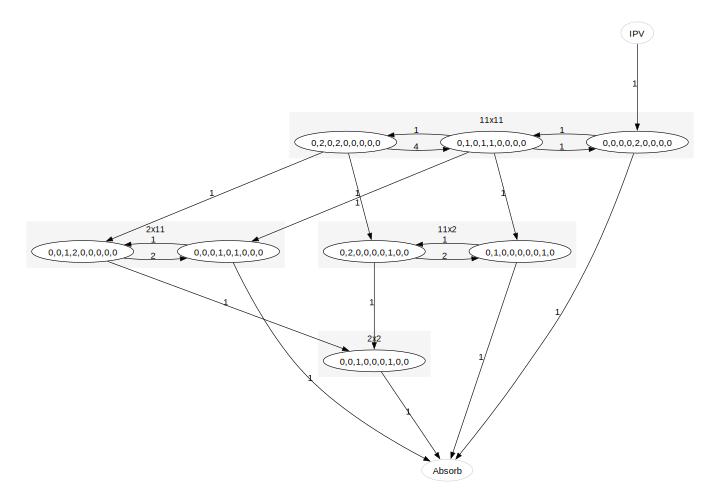

In [13]:
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, #rainbow=TRUE,
               fontsize=15, ranksep=2, nodesep=1, rankdir="TB", subgraphs=TRUE, subgraphfun=nr_at_each_locus, 
           # splines='line'
          )

In [26]:
total_rate <- 4
total_child_rate <- 2
C1 <- 1 / total_rate
R2 <- 1 / total_child_rate
C2 <- 1 / total_child_rate

C1 * C2 / (1 - C1 * R2) * total_rate

[1] 0.5714286

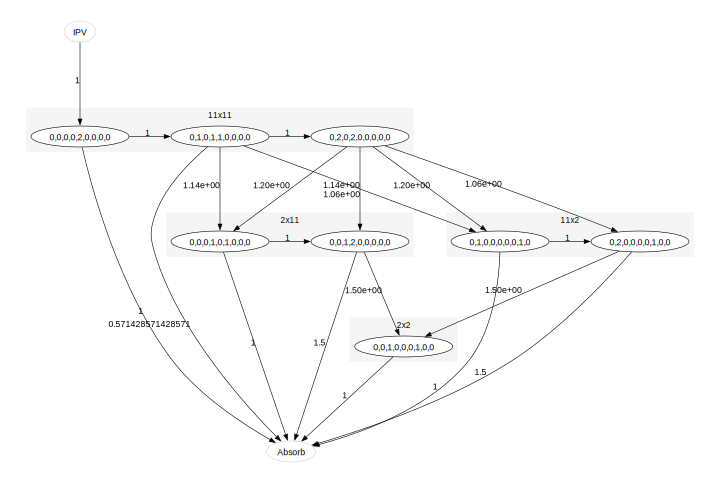

In [594]:
plot_graph(graph_as_matrix(dag_graph), size=c(10, 8), align=TRUE, #rainbow=TRUE,
               fontsize=15, ranksep=2, nodesep=1, rankdir="TB", subgraphs=TRUE, subgraphfun=nr_at_each_locus, 
           # splines='line'
          )

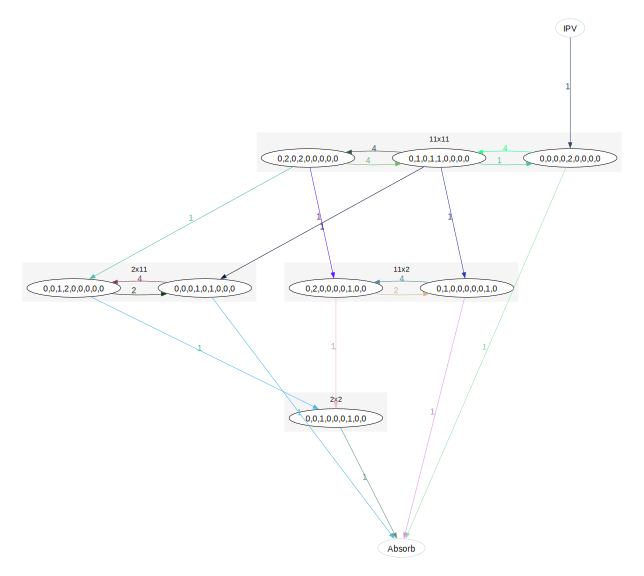

In [420]:
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, rainbow=TRUE,
               fontsize=16, ranksep=3, nodesep=1, rankdir="TB", splines='line',
            subgraphs=TRUE, subgraphfun=nr_at_each_locus,
           # subgraphfun=function(state, index) paste(sum(state), collapse="")
           # subgraphfun=function(state, index) paste(c(sum(state[1:(length(state)/2)]), sum(state[(length(state)/2+1):length(state)])), collapse="")
           )                   

In [433]:
               
# r_construct_twolocus_island_graph <- function(s, N, rec_rate, DAG=FALSE) {

#     # # number of populations
#     # p <- 2 # needs to be 2
#     # # state vector length
#     # n <- p*(s+1)**2
#     # state vector length
#     n <- (s+1)**2

#     graph <- create_graph(n)
#     index <- 1
#     # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
#     state <- rep(0, n)
#     state[props_to_index_two_locus(s, 1, 1, 1)] <- s
#     first_vertex <- find_or_create_vertex(graph, state) # assumes that p=2
#     add_edge(starting_vertex(graph), first_vertex, 1)

#     index <- 2
#     while (index <= vertices_length(graph)) {

#       vertex <- vertex_at(graph, index)
#       state <- vertex$state

#     # print('STATE:')
#     #     print(state)
        
#       count <- 0
#       for (i in 1:n) {
#           count <- count + state[i]
#       }
#       if (count <= 1) {
#           # Only one lineage, stop
#           index <- index + 1
#           next
#       }    

#       ### compute total outgoing rate ###################
#       total_rate <- 0
#       for (i in 1:n) {
#         if (state[i] == 0) next

#         conf_i <- index_to_props_two_locus(s, i)

#         # coalescence #########################
#         for (j in i:n) {
#           if (state[j] == 0) next
            
#           conf_j <- index_to_props_two_locus(s, j)

#           if (i == j) {
#             if (state[i] < 2) {
#               next;
#             }
#             rate <- state[i] * (state[i] - 1) / 2 / N
#           } else {
#             if (state[i] < 1 || state[j] < 1) {
#               next;
#             }
#             rate <- state[i] * state[j] / N
#           }
#          total_rate <- total_rate + rate   
#         }

#         # recombination #######################
#         if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {
#           total_rate <- total_rate + rec_rate
#         }
          
#       }
#             ############
#           C <- rate / total_rate
#           R <- rec_rate / total_rate
#             ############

        
#       #################################################        
        
        
#       for (i in 1:n) {
#         if (state[i] == 0) next

#         conf_i <- index_to_props_two_locus(s, i)

#         # coalescence #########################
#         for (j in i:n) {
#           if (state[j] == 0) next
            
#           conf_j <- index_to_props_two_locus(s, j)

#           if (i == j) {
#             if (state[i] < 2) {
#               next;
#             }
#             rate <- state[i] * (state[i] - 1) / 2 / N
#           } else {
#             if (state[i] < 1 || state[j] < 1) {
#               next;
#             }
#             rate <- state[i] * state[j] / N
#           }

            
#           child_state <- state
            
#           if (DAG) {

#               # if (state_has_relink_only_transition(state)) {
#               #   # States for which is this true have ALL outgoing edges divided by (1-c*r)
#               #   C <- C / (1 - C * R)


                  
#               # }
                
#               child_state[i] <- child_state[i] - 1
#               child_state[j] <- child_state[j] - 1
              
#               stopifnot(conf_i$descendants_l1+conf_j$descendants_l1 <= s)
#               stopifnot(conf_i$descendants_l2+conf_j$descendants_l2 <= s)
#               idx = props_to_index_two_locus(s, conf_i$descendants_l1+conf_j$descendants_l1, conf_i$descendants_l2+conf_j$descendants_l2)
#               child_state[idx] <- child_state[idx] + 1   

#                       # print('child:')
#                       #   print(child_state)
#               # print(c(state_has_relink_only_transition(state), event_is_relink_only_coal(conf_i, conf_j)))
              
#               if (event_is_relink_only_coal(conf_i, conf_j)) {
    
#                   # then find grand_child_states that would result if THAT state saw an intra coalescence
#                   for (k in 1:n) {
#                     conf_k <- index_to_props_two_locus(s, k)
#                     for (l in k:n) {
#                       conf_l <- index_to_props_two_locus(s, l)

#           if (k == l) {
#             if (child_state[k] < 2) {
#               next;
#             }

#           } else {
#             if (child_state[k] < 1 || child_state[l] < 1) {
#               next;
#             }

#           }

                        
#                       # if coal would reducee the number of lineages at at least one locus
#                       # add edge to resulting grand_child state with rate (c*r)
#                       grand_child_state <- child_state
                        
#                       grand_child_state[k] <- grand_child_state[k] - 1
#                       grand_child_state[l] <- grand_child_state[l] - 1
                        
#                       if (conf_k$descendants_l1+conf_l$descendants_l1 > s || conf_k$descendants_l2+conf_l$descendants_l2 > s) {
#                         next
#                       }
#                         # print(c(conf_k$descendants_l1+conf_l$descendants_l1, conf_k$descendants_l2+conf_l$descendants_l2))
    
#                       idx = props_to_index_two_locus(s, conf_k$descendants_l1+conf_l$descendants_l1, conf_k$descendants_l2+conf_l$descendants_l2)
#                       grand_child_state[idx] <- grand_child_state[idx] + 1 

#                         # print('grand:')
#                         # print(grand_child_state)
#                     stopifnot(all(grand_child_state>=0))
                        
#                       rate <- C * R / (1 - C * R) * total_rate
                        
#                       grand_child_vertex <- find_or_create_vertex(graph, grand_child_state)
#                       add_edge(vertex, grand_child_vertex, rate * total_rate)
#                     }
#                   }
#               } else {

#                 if (state_has_relink_only_transition(state)) {
#                     rate <- C / (1 - C * R) * total_rate
#                     } else {
#                     rate <- C * total_rate
#                 }

                  
#                 child_vertex <- find_or_create_vertex(graph, child_state)
#                 add_edge(vertex, child_vertex, rate)
#               }
#          } else {
#               # lineages with index i and j coalesce:  
#               child_state[i] <- child_state[i] - 1
#               child_state[j] <- child_state[j] - 1
#               stopifnot(conf_i$descendants_l1+conf_j$descendants_l1 <= s)
#               stopifnot(conf_i$descendants_l2+conf_j$descendants_l2 <= s)
    
#               # coalescene into lineage with index k
#               k = props_to_index_two_locus(s, conf_i$descendants_l1+conf_j$descendants_l1, conf_i$descendants_l2+conf_j$descendants_l2)
#               child_state[k] <- child_state[k] + 1
    
#               child_vertex <- find_or_create_vertex(graph, child_state)
#               add_edge(vertex, child_vertex, rate)
#             }
#         }

#         # recombination #######################
#         if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {

#           rate <- R * total_rate
#           child_state <- state

#           # a lineage with index i recombines to produce lineages with index k and l
#           k = props_to_index_two_locus(s, conf_i$descendants_l1, 0)
#           l = props_to_index_two_locus(s, 0, conf_i$descendants_l2)
#           child_state[i] <- child_state[i] - 1
#           child_state[k] <- child_state[k] + 1
#           child_state[l] <- child_state[l] + 1

#                       # print('rec child:')
#                       #   print(child_state)

            
#           child_vertex <- find_or_create_vertex(graph, child_state)
#           add_edge(vertex, child_vertex, rate)
#         }

#       }

#       index <- index + 1

#       if ((index %% 50) == 0) {
#         cat(index, vertices_length(graph), "\n")
#       }

#     }
    
#     return(graph)
# }

# sample_size <- 2
# s <- 2
# dag_graph <- r_construct_twolocus_island_graph(sample_size, 1, 3,
#                                            DAG=TRUE
#                                           )

# states <- t(sapply(1:vertices_length(dag_graph), function(index) vertex_at(dag_graph, index)$state, simplify = FALSE))
# ipv <- graph_as_matrix(dag_graph)$IPV
# sim <- graph_as_matrix(dag_graph)$SIM

In [434]:
expectation(dag_graph)

[1] 1.0005

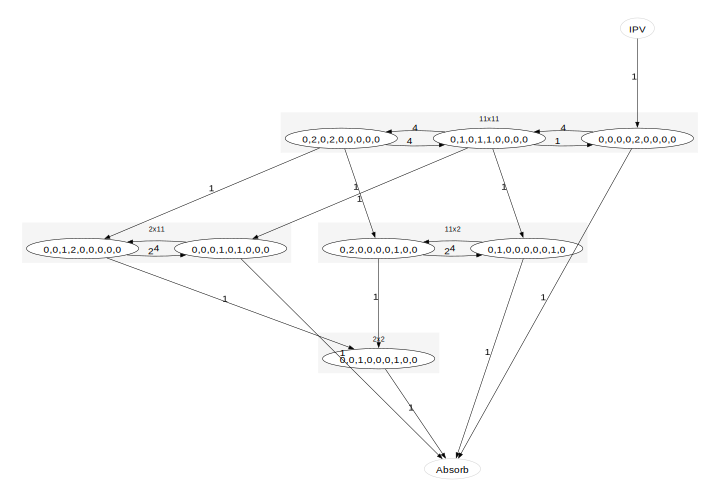

In [435]:
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, #rainbow=TRUE,
               fontsize=20, ranksep=2.5, nodesep=1, rankdir="TB", subgraphs=TRUE, subgraphfun=nr_at_each_locus, splines='line')

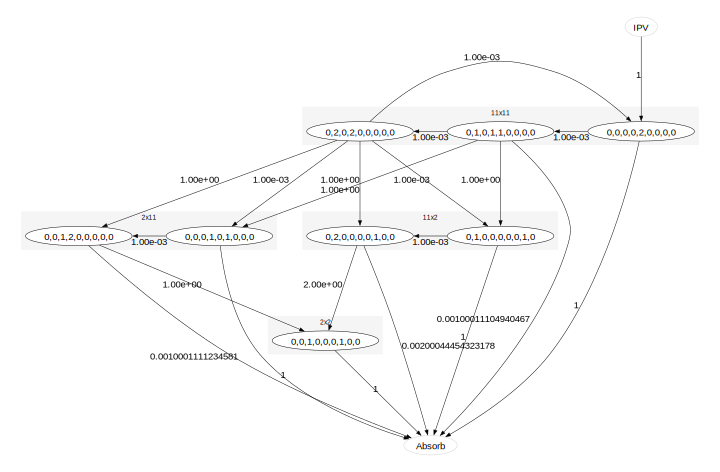

In [436]:
plot_graph(graph_as_matrix(dag_graph), size=c(10, 8), align=TRUE, #rainbow=TRUE,
               fontsize=20, ranksep=2.5, nodesep=1, rankdir="TB", subgraphs=TRUE, subgraphfun=nr_at_each_locus, 
           # splines='line'
          )

In [384]:

graph <- standard_coalescent(sample_size)
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, rainbow=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25,
            subgraphs=TRUE,         
           subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))

ERROR: Error in standard_coalescent(sample_size): could not find function "standard_coalescent"


## State space in C

Zero-probability transistions are ignored, so the state space is reduced when either recombination rate or migration rate are zero.

Each state has the following three properties:
1. nr decendants at locus 1
2. nr decendants at locus 2
3. what population the lineage is currently in

Rccp exports `construct_twolocus_island_graph`, `index_to_props`, and `props_to_index`:

Sample size:

In [11]:
s <- 2

# Sanity checks without migration

## ARG TMRCA without migration

The minimum of two independent exponential random variables (the loci are independent with large recombination rate) with parameters $\lambda$ and $\eta$ is also exponential with parameter $\lambda+\eta$. Also:

$$\mathbb{E}[\min(X_1, X_2) + \max(X_1, X_2)] = \mathbb{E}[X_1 + X_2] = \frac{1}{\lambda} + \frac{1}{\eta}$$

Because 

$$\mathbb{E}[\min(X_1, X_2)] = \frac{1}{\lambda + \eta},$$

we get

$$\mathbb{E}[\min(X_1, X_2)] = \frac{1}{\lambda} + \frac{1}{\eta} - \frac{1}{\lambda + \eta}$$

So for a sample of two, and a coalescence rate of 1, the expected time to coalescence at *both* loci is $1 + 1 - \frac{1}{1+1} = 1.5$. The time for the two loci to coalesce is 1. So the total ARG TMRCA should be 2.5:

In [33]:

graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 0.1)
expectation(graph)

[1] 1.03377

In [34]:
graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 10000000)
expectation(graph)

[1] 2.5

__*Note for Tobias*__: `expectation` does not like null-edges:

In [35]:
# graph <- construct_twolocus_island_graph(2, 1, 1, 0, 0, 10000000, keep_null_edges=TRUE)
# expectation(graph)

## Visualize graph

In [43]:
s <- 2
graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 0.1)
gam <- graph_as_matrix(graph)
gam

$states
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]    0    2    0    2    0    0    0    0    0     0     0     0     0     0
[2,]    0    1    0    1    1    0    0    0    0     0     0     0     0     0
[3,]    0    0    0    0    2    0    0    0    0     0     0     0     0     0
[4,]    0    0    1    2    0    0    0    0    0     0     0     0     0     0
[5,]    0    0    0    1    0    1    0    0    0     0     0     0     0     0
[6,]    0    2    0    0    0    0    1    0    0     0     0     0     0     0
[7,]    0    1    0    0    0    0    0    1    0     0     0     0     0     0
[8,]    0    0    1    0    0    0    1    0    0     0     0     0     0     0
     [,15] [,16] [,17] [,18]
[1,]     0     0     0     0
[2,]     0     0     0     0
[3,]     0     0     0     0
[4,]     0     0     0     0
[5,]     0     0     0     0
[6,]     0     0     0     0
[7,]     0     0     0     0
[8,]     0     0     0     0

$SIM
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,] -6.0  4.0  0.0  1.0  0.0  1.0  0.0    0
[2,]  0.1 -3.1  1.0  0.0  1.0  0.0  1.0    0
[3,]  0.0  0.1 -1.1  0.0  0.0  0.0  0.0    0
[4,]  0.0  0.0  0.0 -3.0  2.0  0.0  0.0    1
[5,]  0.0  0.0  0.0  0.1 -1.1  0.0  0.0    0
[6,]  0.0  0.0  0.0  0.0  0.0 -3.0  2.0    1
[7,]  0.0  0.0  0.0  0.0  0.0  0.1 -1.1    0
[8,]  0.0  0.0  0.0  0.0  0.0  0.0  0.0   -1

$IPV
[1] 0 0 1 0 0 0 0 0

$indices
[1]  7  4  2  8  5  9  6 10

# check this. the graph does not look ok...

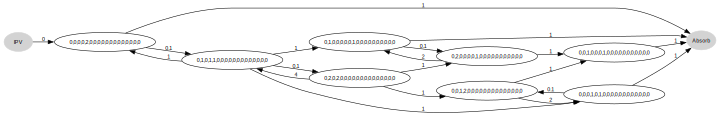

In [47]:
plot_graph(gam, size=c(10,20))

In [108]:
index_to_props(s, 4)

$locus1
[1] 1

$locus2
[1] 0

$population
[1] 1

## Two-locus SFS without recombination

Expected ARG branches with i and j tons at each locus

In [109]:
s <- 5

graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 0)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
print(vertices_length(graph))

[1] 8


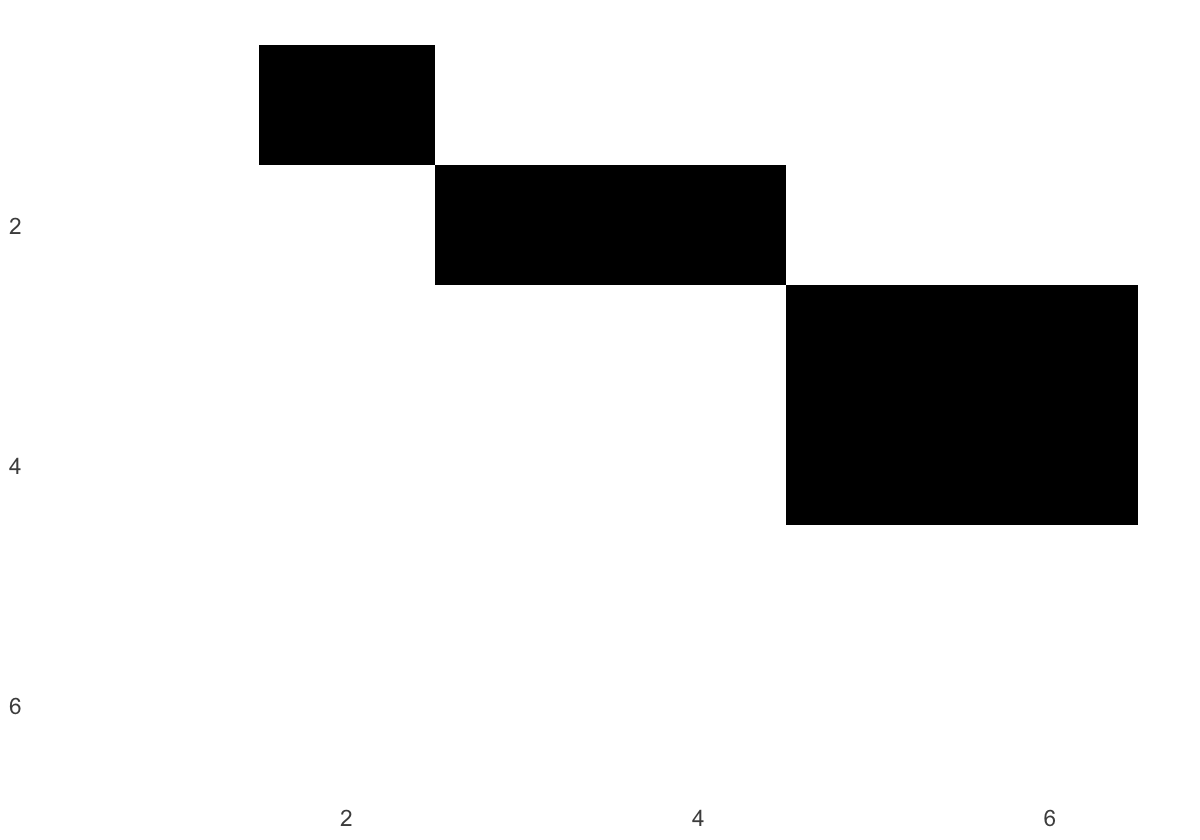

In [110]:
plot_sim(graph)

In [111]:
exp_mat <- matrix(nrow=s+1,ncol=s+1)
for (i in 1:s) {
  for (j in 1:s) {
    exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
  }
}

In [112]:
nrow(rewards)

[1] 72

In [113]:
rewards

0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,5,3,1,2,0,1,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0


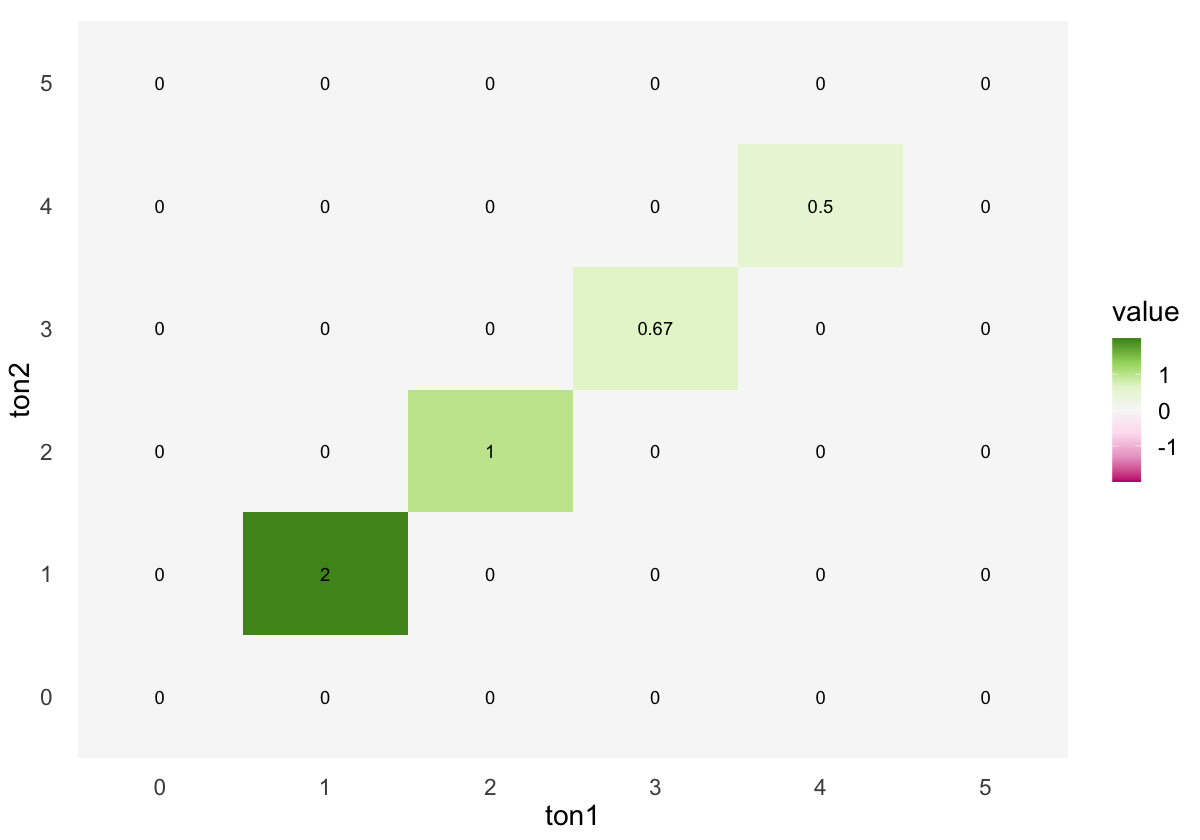

In [114]:
plot_exp_mat(get_exp_mat(graph, rewards, s))

## Two-locus SFS with recombination

Expected ARG branches with i and j tons at each locus

In [200]:
s <- 4
graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 5000)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
expectation(graph)
print(vertices_length(graph))

[1] 3.051167

[1] 110


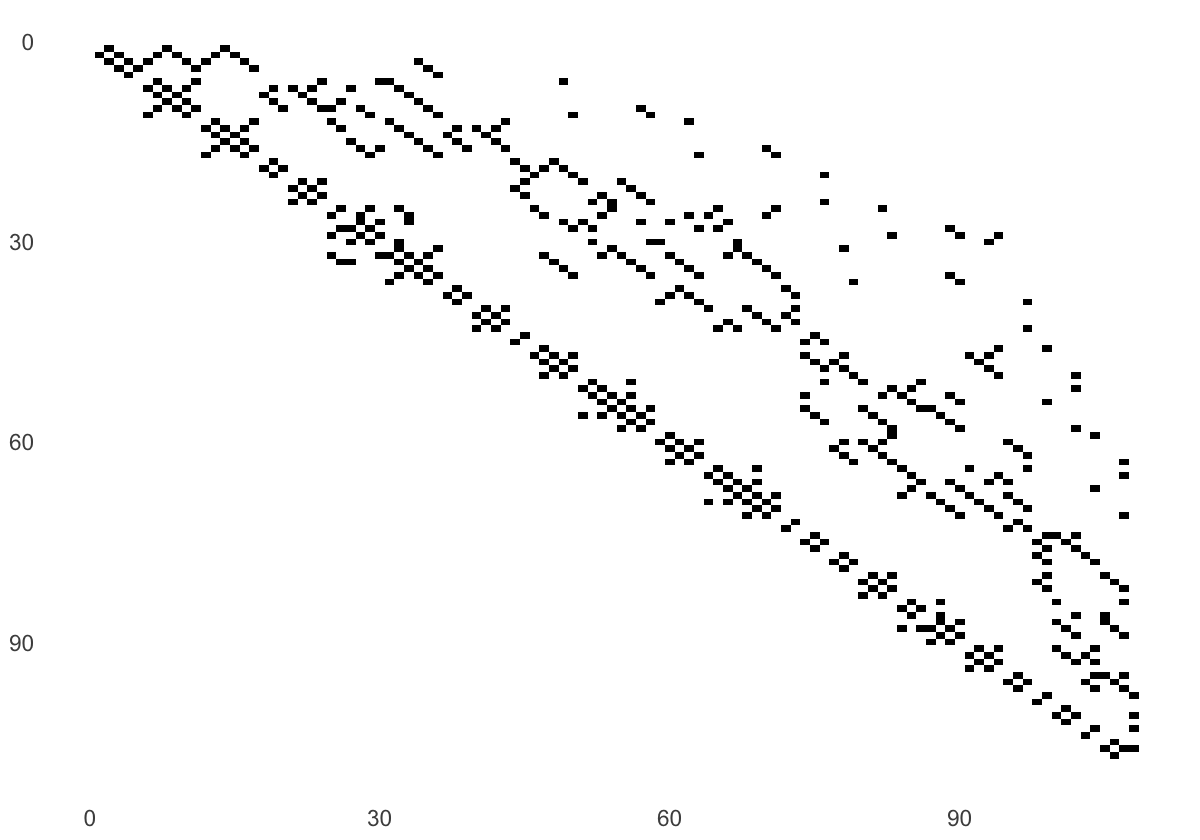

In [201]:
plot_sim(graph)

In [202]:
exp_mat <- get_exp_mat(graph, rewards, s)

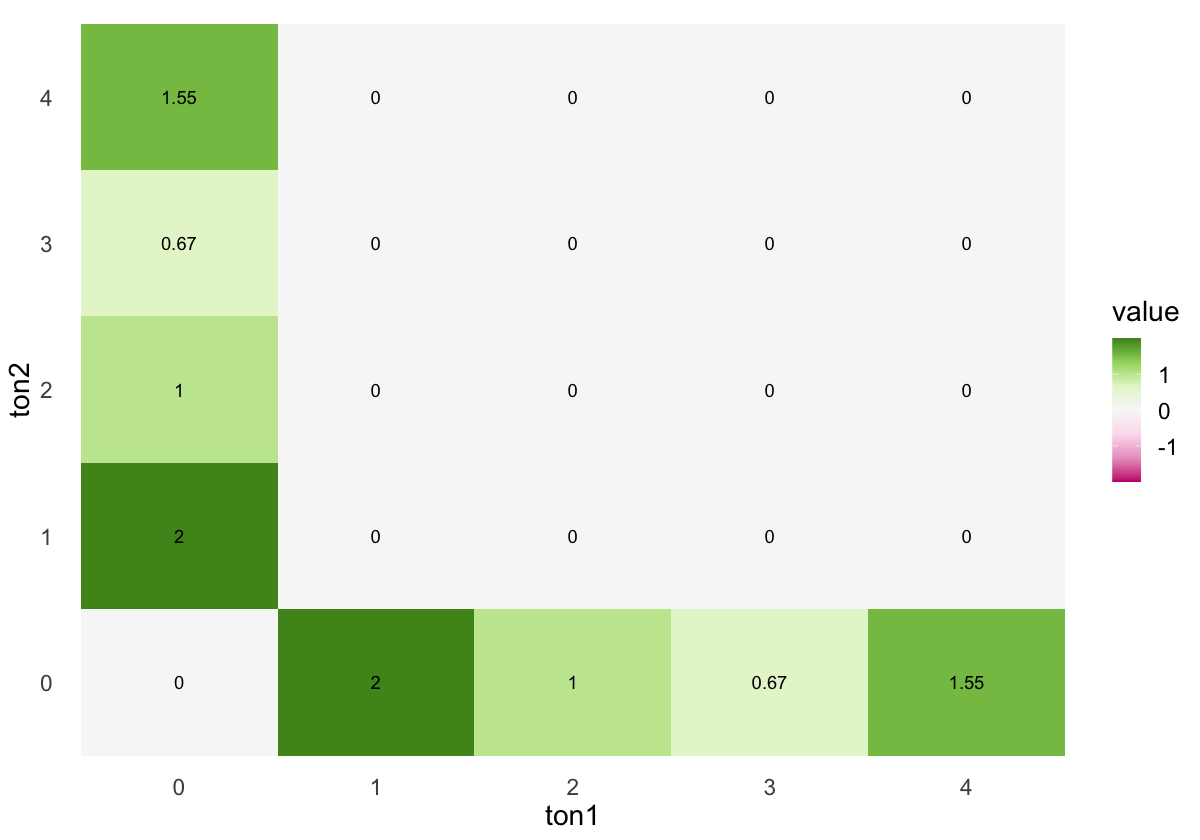

In [203]:
plot_exp_mat(exp_mat)

Marginal SFSs:

In [174]:
x <- colSums(exp_mat)
sfs_locus1 <- x[c(-1, -length(x))]
x <- rowSums(exp_mat)
sfs_locus2 <- x[c(-1, -length(x))]

Fits expectations for a single locus:

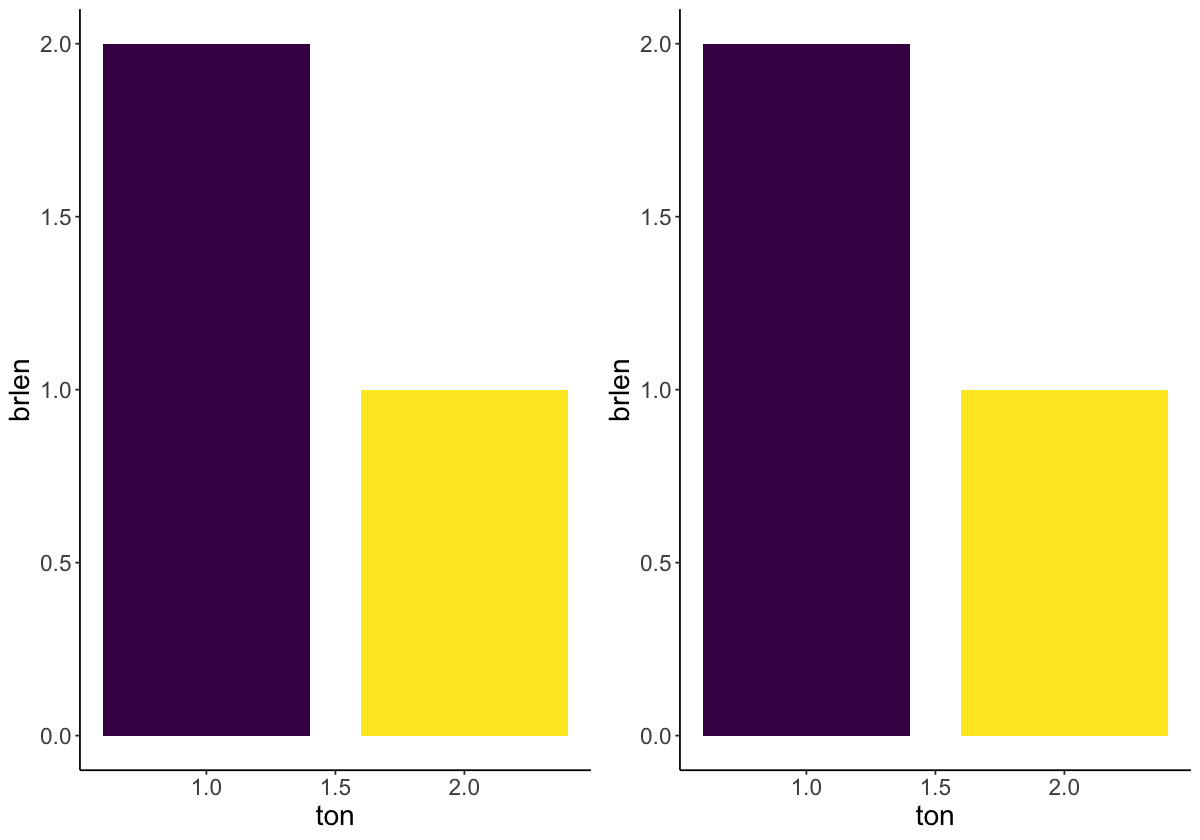

In [175]:
grid.arrange(
    data.frame(
      ton=seq(1,length(sfs_locus1)),  
      brlen=sfs_locus1
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    data.frame(
      ton=seq(1,length(sfs_locus2)),  
      brlen=sfs_locus2
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    nrow = 1)


# PDFs of ARG branch length with i and j descendants at each locus

In [121]:
result = data.frame()
for (i in 1:(s-1)) {
    for (j in 1:(s-1)) {
        x <- seq(from = 0, to = 4, by = 0.01)
        pdf <- dph(x, reward_transform(graph, rewards[props_to_index(s, i, j, 1),]))

        df <- data.frame(prob = pdf, t=x, i_ton=i, j_ton=j, color=100*j+i)
        result <- rbind(result, df)
    }
}
#result %>% ggplot(aes(y=prob, x=t, color=ton, group=ton)) + geom_line(size=1)

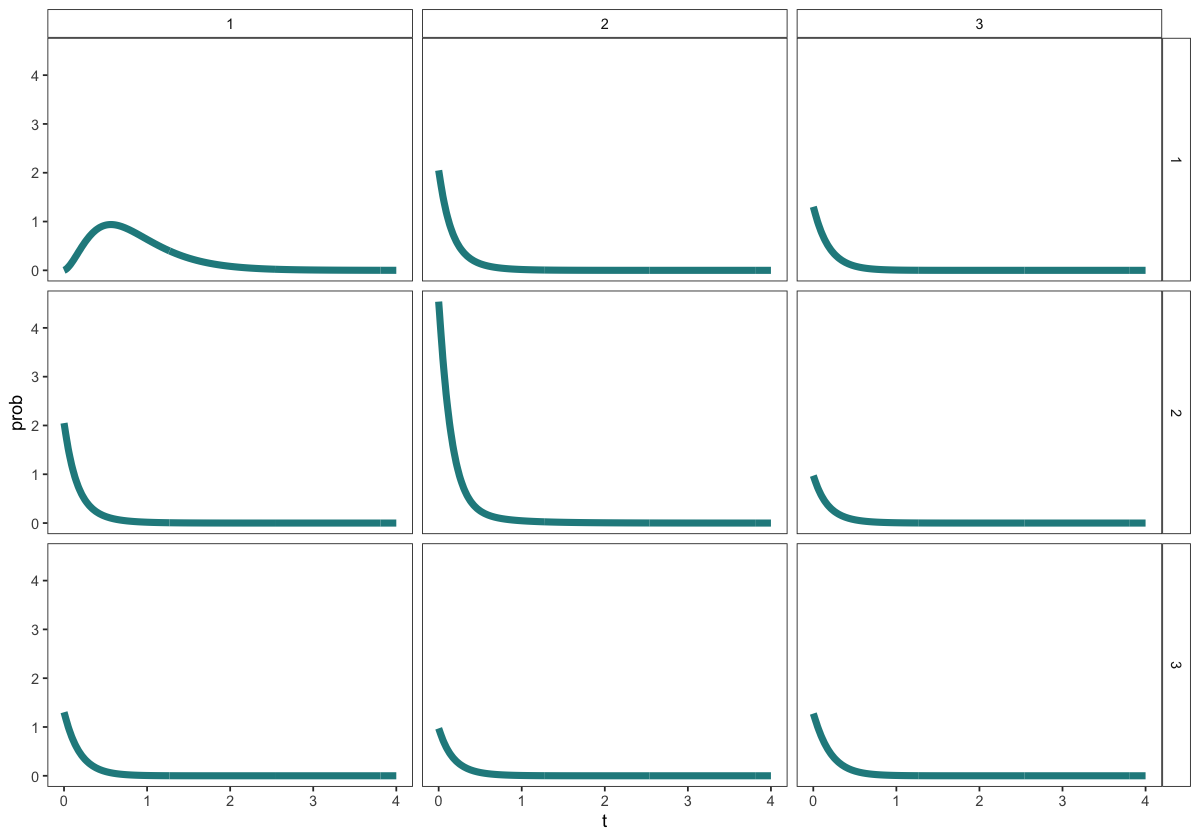

In [122]:
ggplot(result, aes(y=prob, x=t)) + geom_line(linewidth=2, color='#238A8DFF') +
    facet_grid(i_ton ~ j_ton) +
    theme_bw() + theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), strip.background = element_rect(fill="white"))
ggsave('~/Desktop/tmp.pdf', width=7, height=6)

# ARG TMRCA without recombination

Test the classical result that with symmetric migration and sampling from one population, the expectation should be the sum of the two population sizes (2) and independent of the migration rate. The variance is not and should fall with higher migration rate and asymptotically reach (4):

In [123]:
graph <- construct_twolocus_island_graph(2, 1, 1, 10000000000, 10000000000, 0)
variance(graph)

[1] 4

In [124]:
expectation_migrates <- c()
variance_migrates <- c()
mig_rates <- 10^(-5:5)
for (mig_rate in mig_rates) {
    graph <- construct_twolocus_island_graph(2, 1, 1, mig_rate, mig_rate, 0)
    expectation_migrates <- c(expectation_migrates, expectation(graph))
    variance_migrates <- c(variance_migrates, variance(graph))   
}

In [125]:
data.frame(mig_rates=mig_rates, expectation_migrates=expectation_migrates)

mig_rates,expectation_migrates
<dbl>,<dbl>
1e-05,2
1e-04,2
1e-03,2
1e-02,2
1e-01,2
1e+00,2
1e+01,2
1e+02,2
1e+03,2


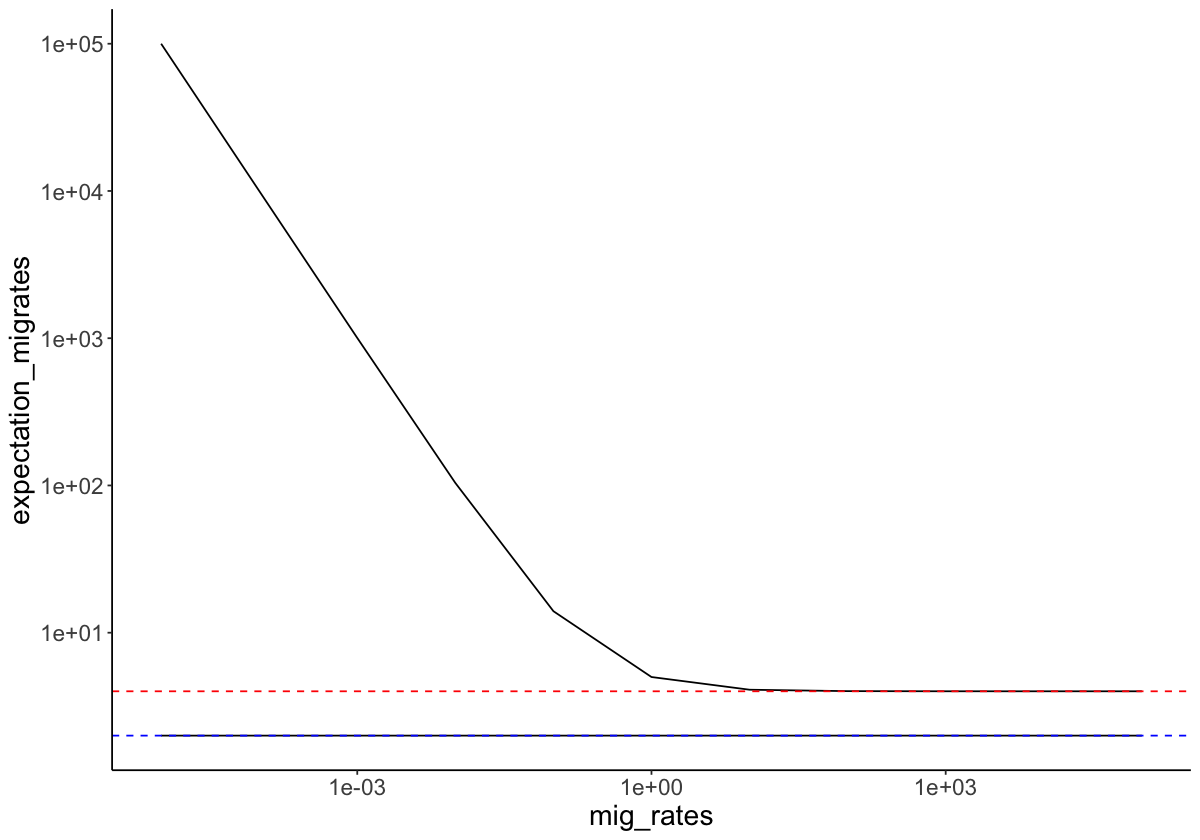

In [126]:
ggplot(data.frame(mig_rates=mig_rates, 
                         expectation_migrates=expectation_migrates),
             aes(x=mig_rates, expectation_migrates)) +
    geom_line() +
    geom_line(data=data.frame(mig_rates=mig_rates, 
                         variance_migrates=variance_migrates),
             aes(x=mig_rates, variance_migrates)) +
        scale_x_continuous(trans='log10') + 
        scale_y_continuous(trans='log10') +
        geom_hline(yintercept = 2, color='blue', linetype='dashed') +
        geom_hline(yintercept = 4, color='red', linetype='dashed') + despine

# Distribution of number of outgoing edes

In [151]:
s <- 3

In [152]:
graph <- construct_twolocus_island_graph(s, 1, 1, 0, 0, 1)
print(vertices_length(graph))
si <- sign(graph_as_matrix(graph)$SIM)
diag(si) <- 0
outgoing_edge_counts <- rowSums(si)
# qplot(outgoing_edge_counts)

[1] 32


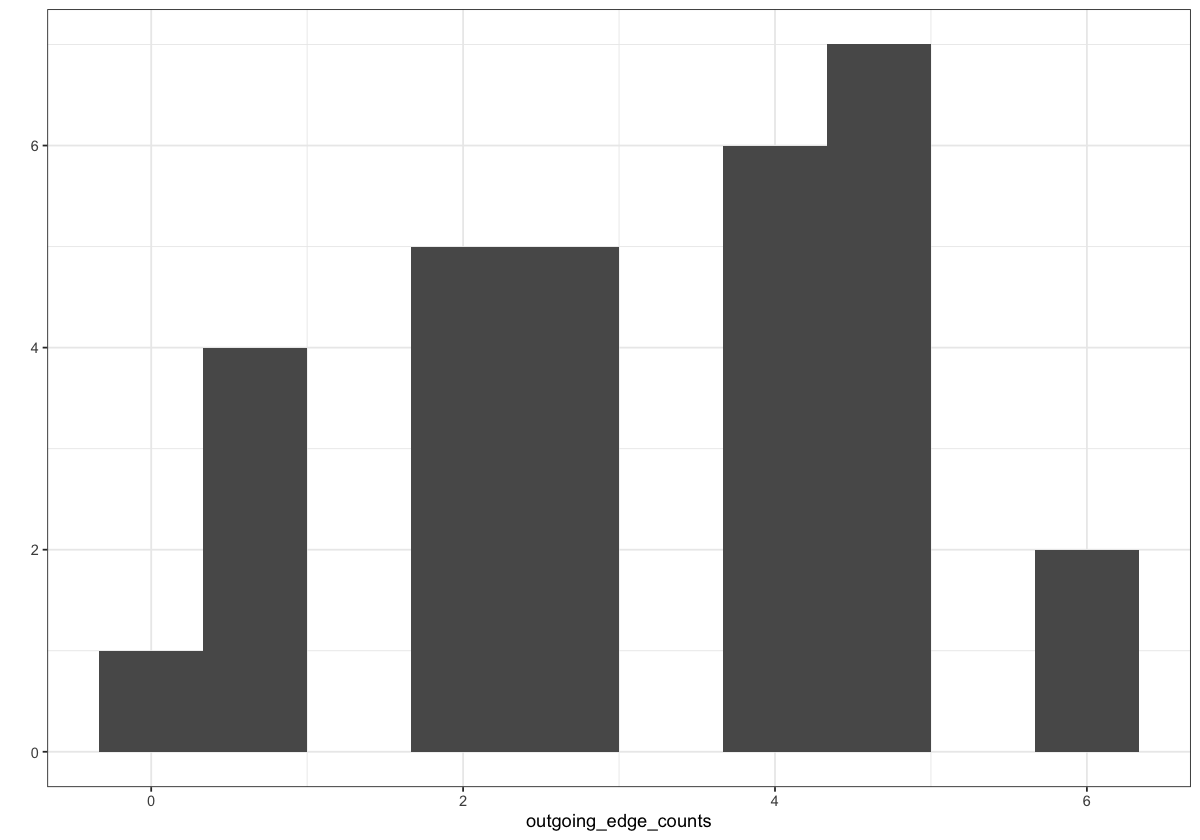

In [153]:
qplot(outgoing_edge_counts, bins=10)

# Matrix sparcity

In [154]:
gam <- graph_as_matrix(graph)
mean(as.integer(gam$SIM > 0))

[1] 0.1111111

Saving 7 x 7 in image


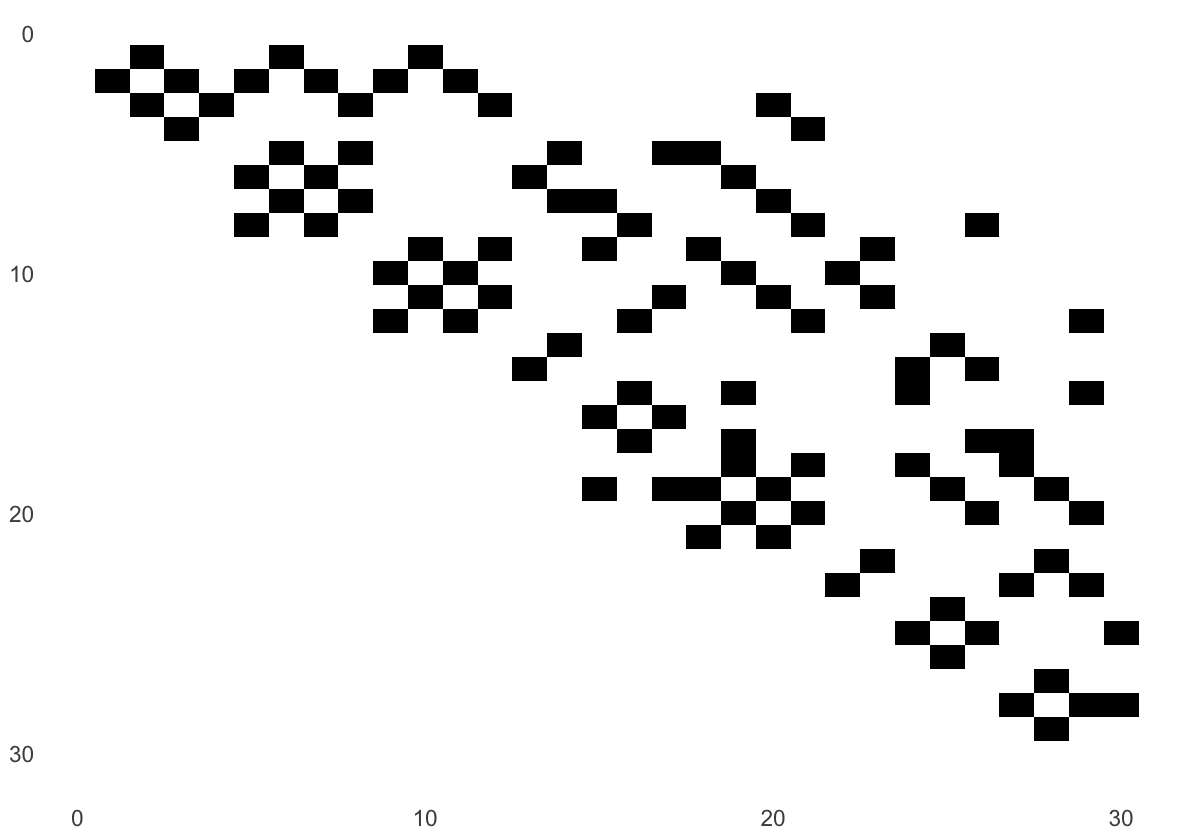

In [155]:
plot_sim(graph)
ggsave('~/Desktop/tmp.pdf')

In [156]:
g <- construct_twolocus_island_graph(5, 1, 1, 1, 1, 1)
vertices_length(g)

[1] 6771

# Two-locus SFS

Expected ARG branches with i and j tons at each locus

In [157]:
# %%R -o s
# s <- 4

No migration:

In [158]:
# %%R
# graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 1)
# rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
# vertices_length(graph)

In [159]:
# %%R

# library(foreach)
# foreach (i=1:3) %do% {
#   sqrt(i)
# }

In [163]:
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

two_locus_expectation <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    }
    return(exp_mat)
} 

In [164]:
exp_mat <- two_locus_expectation(s, 1, 0, 1)
exp_mat

0.0000000,0.4786735,0.3587595,0.2705236
0.4786735,1.3457452,0.0683782,0.1072031
0.3587595,0.0683782,0.4513478,0.1215144
0.2705236,0.1072031,0.1215144,0.0000000


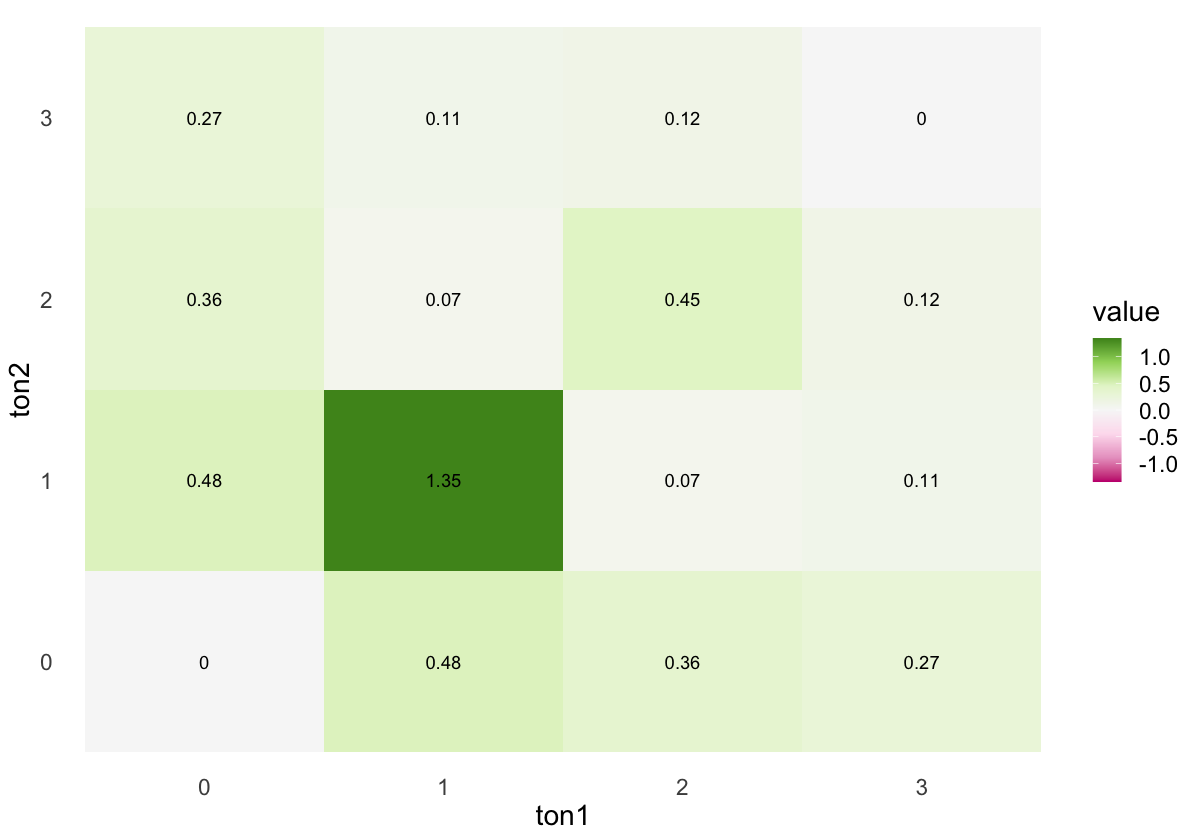

In [165]:
plot_exp_mat(exp_mat) 

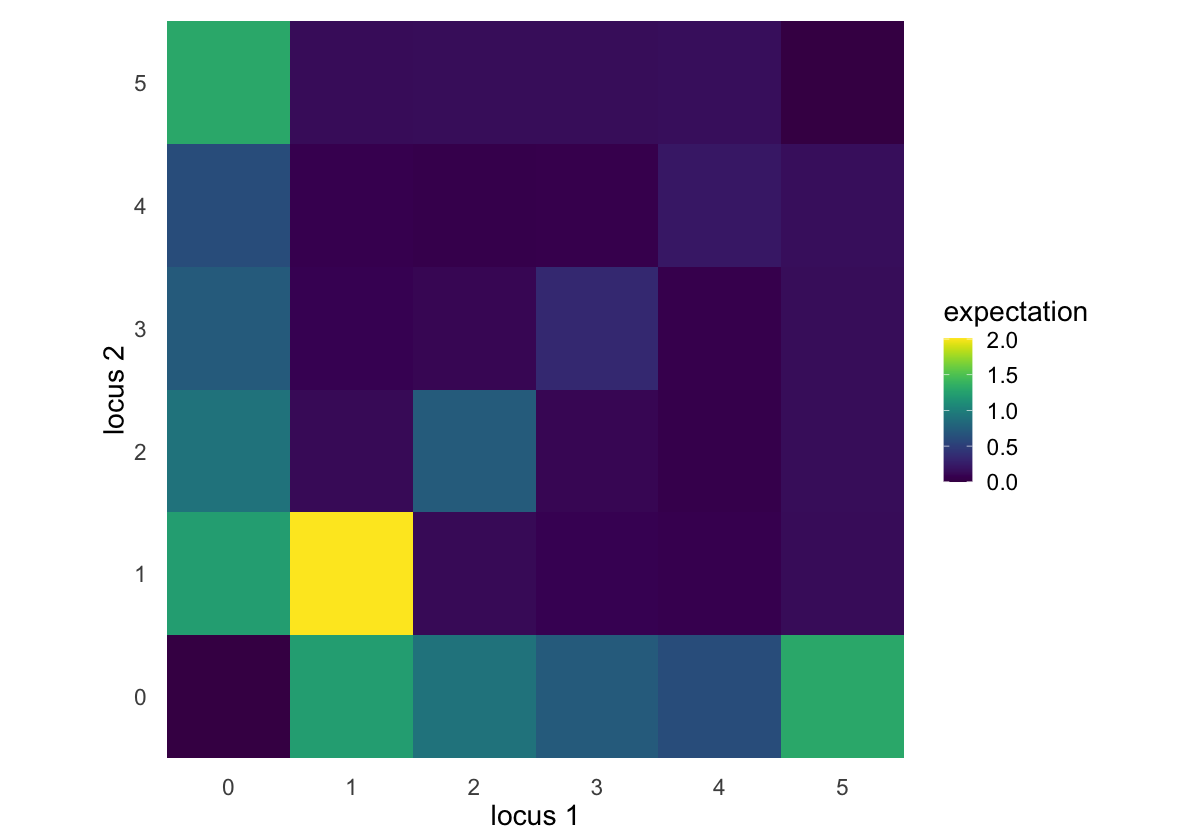

In [47]:
df <- as.data.frame(exp_mat) #%>% gather()
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))

ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_fill_viridis() +
theme_minimal() +
theme(aspect=1) + labs(y = "locus 2", x = "locus 1", fill='expectation') +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

ggsave('~/Desktop/tmp.pdf', width=6, height=6)

# Covriance between tons at locus one

In [48]:
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

ton_covariance_within_locus <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus1_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}    

No migration and no recombination:

In [49]:
cov_mat_no_mig <- ton_covariance_within_locus(s, 1, 0, 0) 

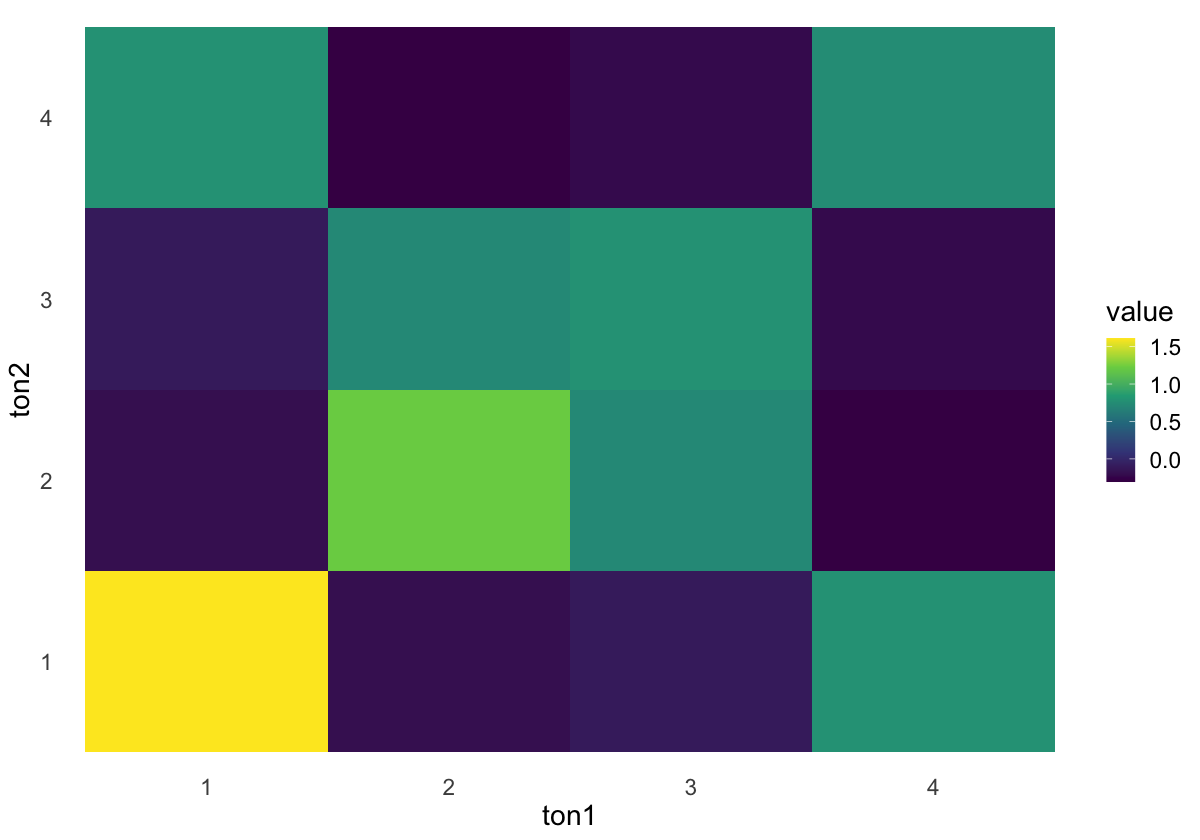

In [50]:
plot_cov_mat(cov_mat_no_mig)

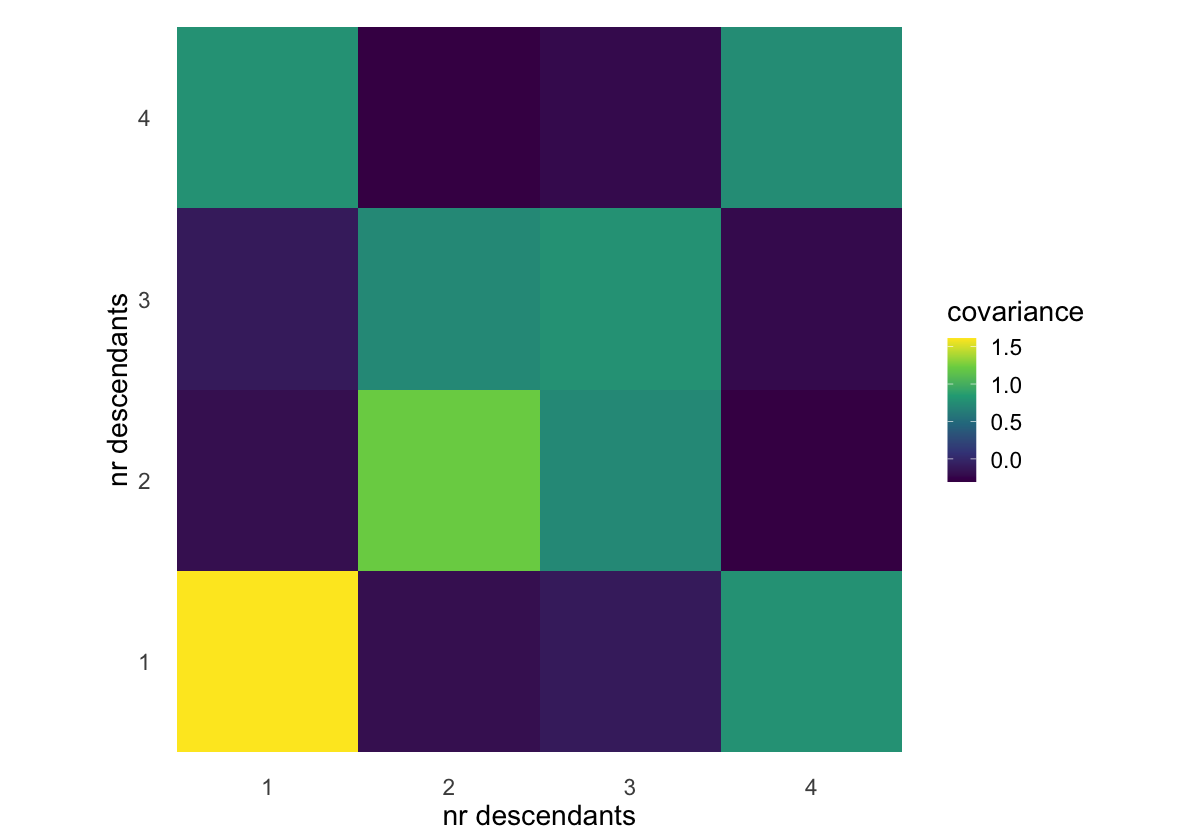

In [51]:
plot_cov_mat(cov_mat_no_mig) + theme(aspect=1) + labs(y = "nr descendants", x = "nr descendants", fill='covariance')
ggsave('~/Desktop/tmp.pdf', width=4.7, height=4.7)

# Covriance between tons between loci

In [52]:
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

ton_covariance_between_loci <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }
    locus2_rewards <- function(j) {
        colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(graph, locus1_rewards(i), locus2_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}    

No migration and no recombination:

In [53]:
cov_mat_no_rec_no_mig <- ton_covariance_between_loci(s, 1, 0, 0) 

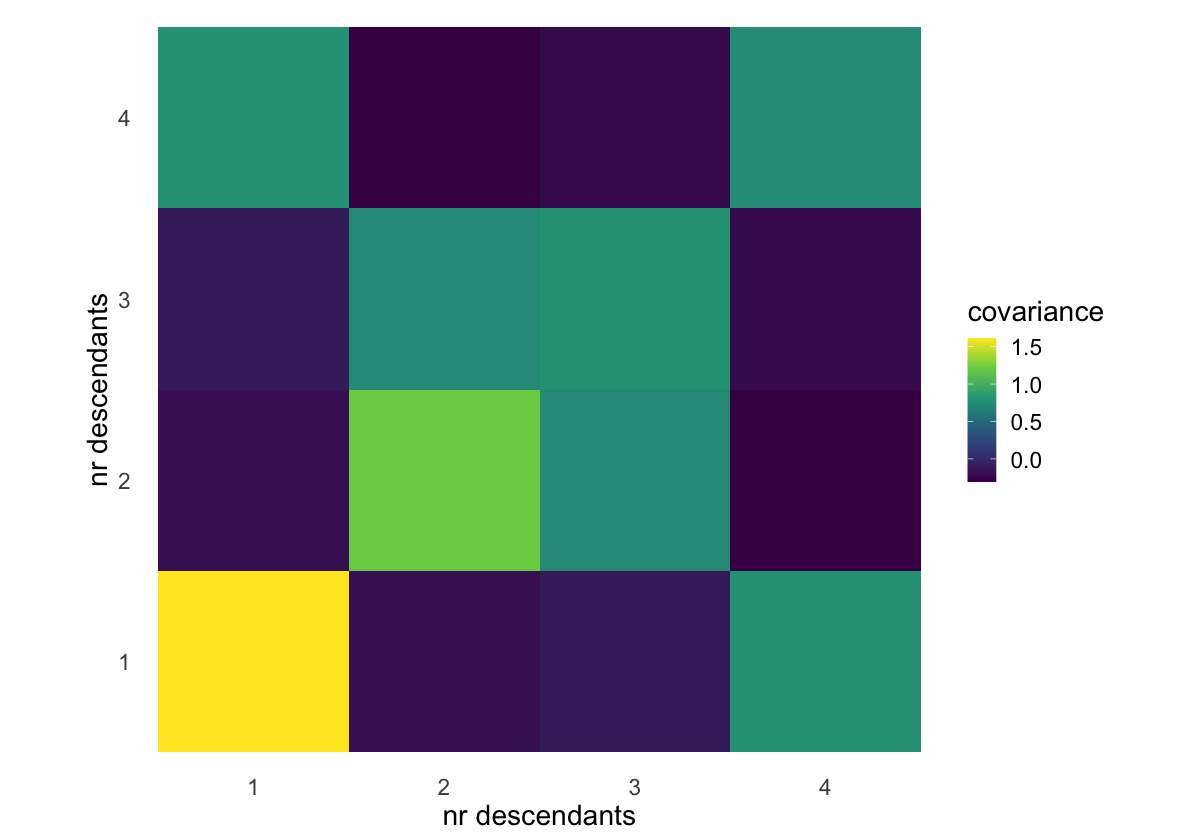

In [54]:
plot_cov_mat(cov_mat_no_rec_no_mig) + theme(aspect=0.95) + labs(y = "nr descendants", x = "nr descendants", fill='covariance')

With recombination:

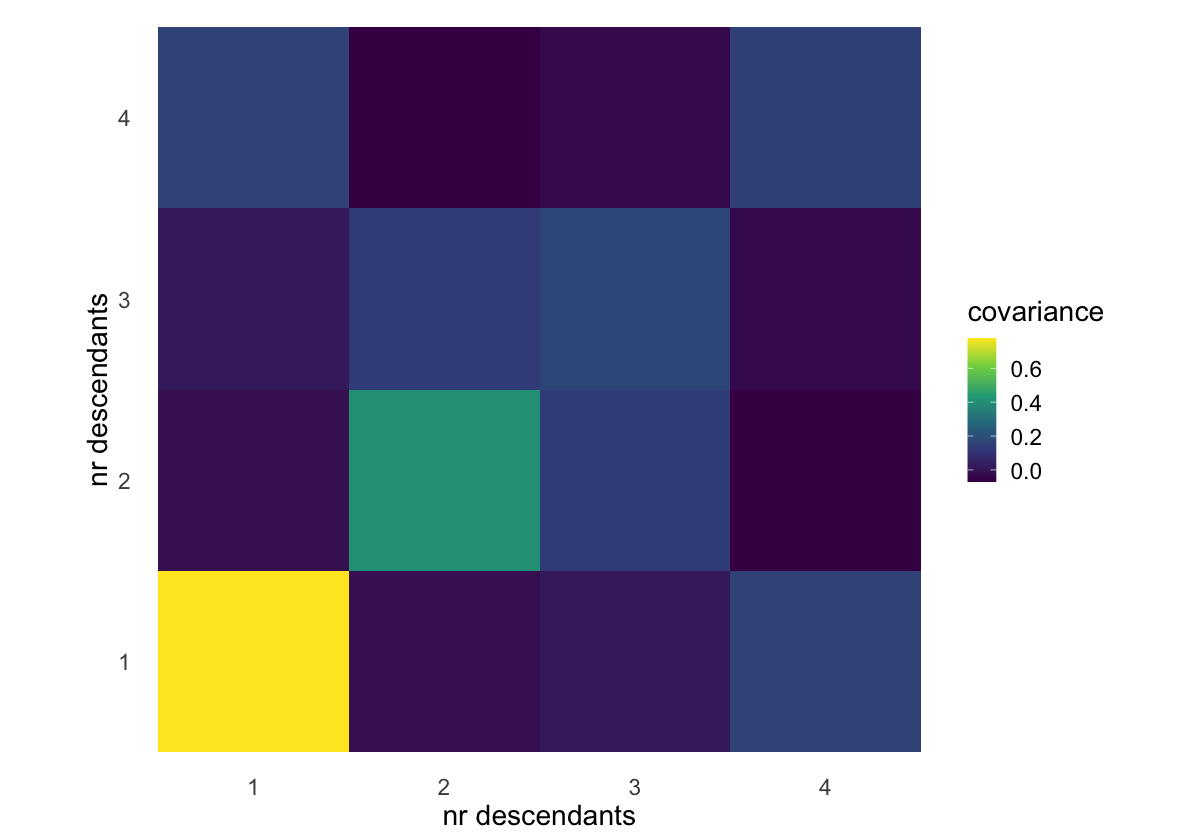

In [55]:
cov_mat_no_mig <- ton_covariance_between_loci(s, 1, 0, 1)
plot_cov_mat(cov_mat_no_mig) + theme(aspect=0.95) + labs(y = "nr descendants", x = "nr descendants", fill='covariance')
ggsave('~/Desktop/tmp.pdf', width=4.7, height=4.7)

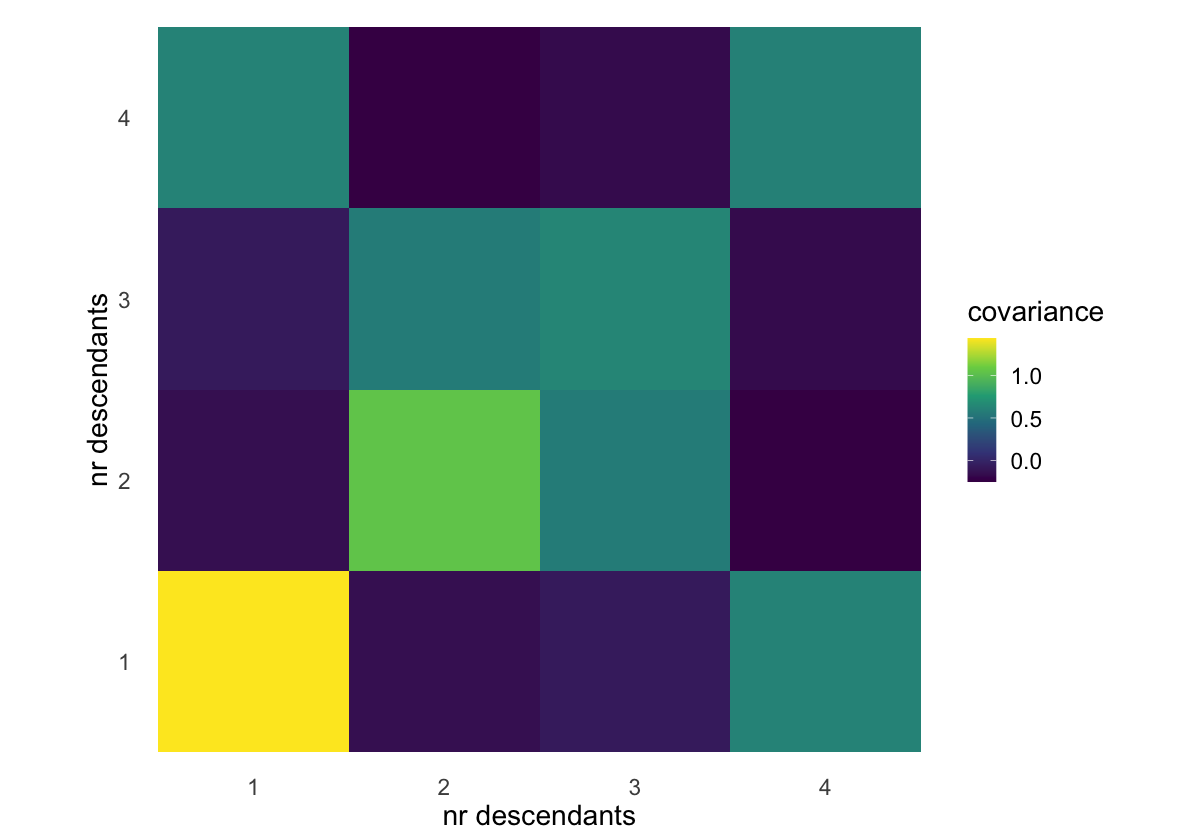

In [56]:
cov_mat_low_rec <- ton_covariance_between_loci(s, 1, 0, 0.1) 
plot_cov_mat(cov_mat_low_rec) + theme(aspect=0.95) + labs(y = "nr descendants", x = "nr descendants", fill='covariance')

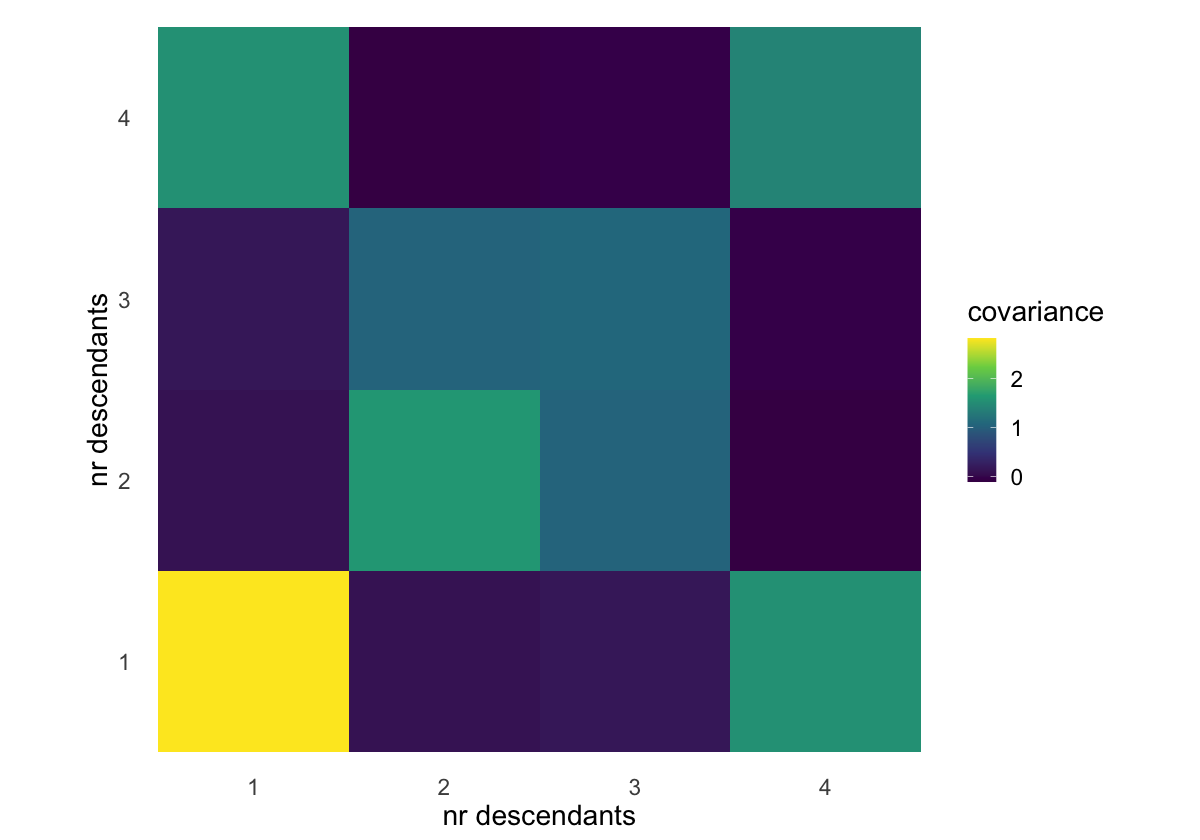

In [57]:
cov_mat_mig <- ton_covariance_between_loci(s, 1, 0.1, 1) 
plot_cov_mat(cov_mat_mig)  + theme(aspect=0.95) + labs(y = "nr descendants", x = "nr descendants", fill='covariance')

# Two locus two islands

# Covariance of ARG branches in the two populations

Covariance of two-locus "ton" branch length (e.g. singletons at locus 1 and doubletons at locus 2) spent in each population.

In [58]:
graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 1)
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

In [59]:
fun <- function(a, b) {
    mapply(function(i, j) covariance(graph, 
                                     rewards[props_to_index(s, i, j, 1),], 
                                     rewards[props_to_index(s, i, j, 2),]), 
           a, b)
}
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

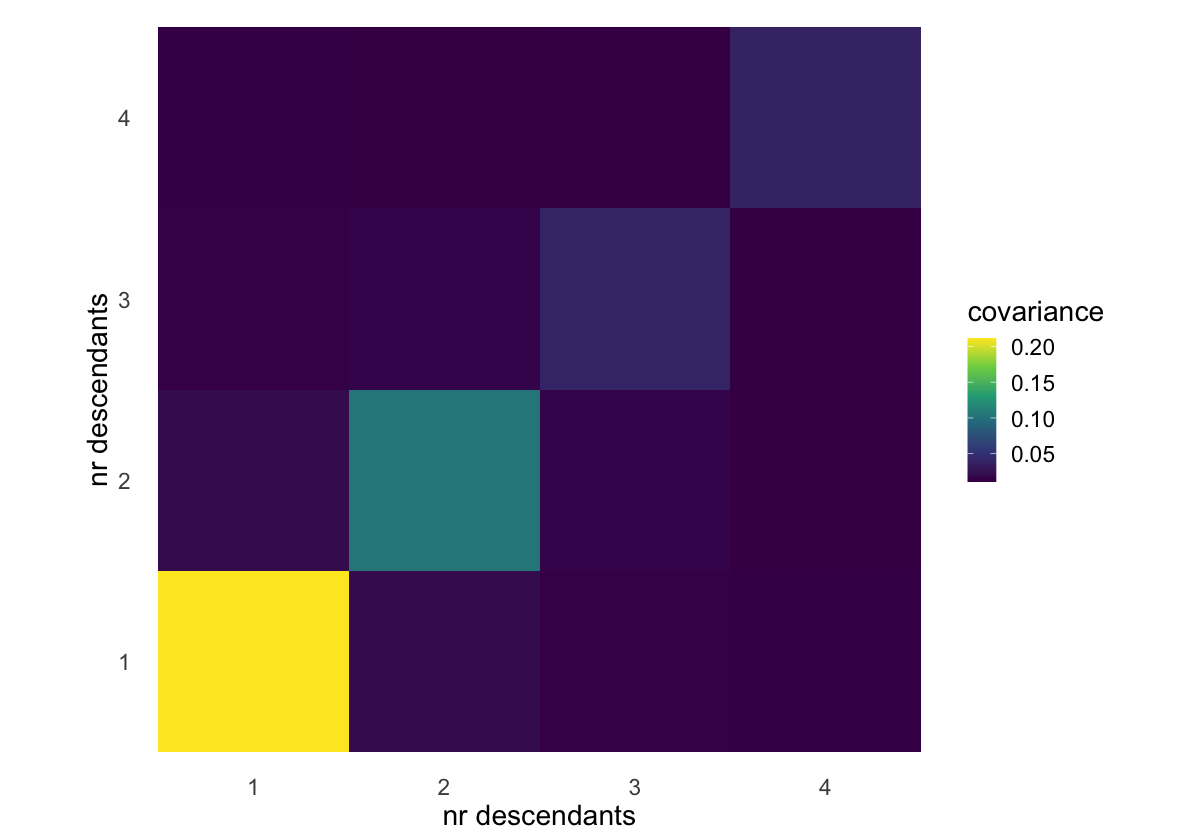

In [60]:
plot_cov_mat(cov_mat) + theme(aspect=0.95) + labs(y = "nr descendants", x = "nr descendants", fill='covariance')
ggsave('~/Desktop/tmp.pdf', width=4.7, height=4.7)

Shows that when there are hte same number of decendants at each locus (mostly becuase of no recombination) then the covariance is highest. Mostly for small tons where there are many lineages to back and forth between popoulations.

In [61]:
# %%R

# setClass("conf", slots=list(locus1="numeric", locus2="numeric", population="numeric"))

# obj <- new("conf", locus1=3, locus2=2, population=1)
# obj@population

# r_index_to_props <- function(s, i) {
#     #' returns the locus1, locus2, population
#     #' conformation of lineages represented by
#     #' state vector index i.
#     stopifnot(i > 0)
#     d <- s + 1 # dim
#     idx <- i - 1
#     p <- idx %/% d**2
#     stopifnot(i <= 2*d**2)
#     a <- (idx - p*d**2) %/% d
#     b <- (idx - p*d**2) %% d
#     return(new("conf", locus1=a, locus2=b, population=p+1))
# }
# r_props_to_index <- function(s, a, b, p) {
#     #' returns the state vector index representing
#     #' the locus1, locus2, population conformation.
#     d <- s + 1
#     i = (p-1)*d**2 + a*d + b + 1
#     return(i)
# }

# Fit landscapes

## Discrete versions

In [ ]:
# disc_two_locus_expectation <- function(s, N, M, R) 
# {    
#     graph <- construct_twolocus_island_graph(s, N, N, M, M, R)

#     mutation_graph <- clone_graph(graph)
#     rewards <- make_discrete(mutation_graph, mutation_rate)
    
#     exp_mat <- matrix(nrow=s+1,ncol=s+1)
#     for (i in 0:s) {
#       for (j in 0:s) {
#         exp_mat[i+1,j+1] <- expectation(mutation_graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
#       }
#     }
#     return(exp_mat)
# } 


# self-transition rate:
mutation_rate <- 0.0001

disc_two_locus_expectation <- function(s, N, M, R) 
{    
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)

    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, mutation_rate)
    
    exp_mat <- matrix(nrow=s-1,ncol=s-1)
    for (i in 1:(s-1)) {
      for (j in 1:(s-1)) {
        exp_mat[i,j] <- expectation(mutation_graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    }
    return(exp_mat)
} 

disc_ton_covariance_within_locus <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    
    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, mutation_rate)
    
    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus1_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}  

disc_ton_covariance_between_loci <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)

    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, 1)
    
    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }
    locus2_rewards <- function(j) {
        colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus2_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
} 

In [ ]:
mat <- disc_two_locus_expectation(5, 1, 1, 1)
plot_exp_mat(mat) +
scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_fill_viridis() +
theme_minimal() +
theme(aspect=1) + labs(y = "locus 2", x = "locus 1", fill='expectation') +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

ggsave('~/Desktop/tmp.pdf', width=6, height=6)

mat <- disc_two_locus_expectation(5, 1, 1, 1)
df <- as.data.frame(mat) #%>% gather()
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_fill_viridis() +
theme_minimal() +
theme(aspect=1) + labs(y = "locus 2", x = "locus 1", fill='expectation') +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

ggsave('~/Desktop/tmp.pdf', width=6, height=6)

In [ ]:

N <- 1
for (M in c(0.1, 1, 10)) {
    for (R in c(0.1, 1, 10)) {
        file_name <- paste('~/Desktop/tmp_M=', M, '_R=', R, '.pdf', sep='')
    
        mat <- disc_ton_covariance_between_loci(5, N, M, R)
        plot_cov_mat(mat) + theme(aspect=0.95) + labs(y = "locus 2", x = "locus 1", fill='covariance')
        ggsave(file_name, width=4.7, height=4.7)
    }
}

In [ ]:
N <- 1
M <- 0.01

for (R in c(0.1, 1, 10)) {
    file_name <- paste('~/Desktop/tmp_M=', M, '_R=', R, '.pdf', sep='')

    mat <- disc_ton_covariance_between_loci(5, N, M, R)
    plot_cov_mat(mat) + theme(aspect=0.95) + labs(y = "locus 2", x = "locus 1", fill='covariance')
    ggsave(file_name, width=4.7, height=4.7)
}

N <- 1
M <- 0.1

for (R in c(0.1, 1, 10)) {
    file_name <- paste('~/Desktop/tmp_M=', M, '_R=', R, '.pdf', sep='')

    mat <- disc_ton_covariance_between_loci(5, N, M, R)
    plot_cov_mat(mat) + theme(aspect=0.95) + labs(y = "locus 2", x = "locus 1", fill='covariance')
    ggsave(file_name, width=4.7, height=4.7)
}

In [ ]:
N <- 1
R <- 1

for (M in c(0.01, 0.1, 1)) {
    file_name <- paste('~/Desktop/tmp_M=', M, '_R=', R, '.pdf', sep='')
    mat <- disc_ton_covariance_between_loci(5, N, M, R)
    plot_cov_mat(mat) + theme(aspect=0.95) + labs(y = "locus 2", x = "locus 1", fill='covariance')
    ggsave(file_name, width=4.7, height=4.7)
}

In [ ]:
#disc_cov_mat_no_rec_no_mig <- disc_ton_covariance_between_loci(5, 1, 1, 0.5, 0.5, 20) 

## Single core

In [ ]:
# s <- 5

# expected_cov_mat <- ton_covariance_between_loci(s, 1, 0.5, 2)
# # expected_cov_mat <- (expected_cov_mat - mean(expected_cov_mat)) / sd(expected_cov_mat)

# expected_exp_mat <- two_locus_expectation(s, 1, 0.5, 2)
# # expected_exp_mat <- (expected_exp_mat - mean(expected_exp_mat)) / sd(expected_exp_mat)


# fit <- function(N, M) {
#     observed_cov_mat <- ton_covariance_between_loci(s, N, M, 2)
#     # observed_cov_mat <- (observed_cov_mat - mean(observed_cov_mat)) / sd(observed_cov_mat)
    
#     observed_exp_mat <- two_locus_expectation(s, N, M, 2)
#     # observed_exp_mat <- (observed_exp_mat - mean(observed_exp_mat)) / sd(observed_exp_mat)
    
#     cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
#     exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
#     return(exp_fit + cov_fit)
# }

# n <- seq(0.5, 1.5, 0.05)
# m <- seq(0.1, 1.1, 0.05)
# params <- expand.grid(n, m)
# fit_mat <- matrix(mapply(fit, params$Var1, params$Var2), nrow=length(n),ncol=length(m))

# rownames(fit_mat) <- n
# colnames(fit_mat) <- m

# df <- as.data.frame(fit_mat) #%>% gather()
# df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
# df$n <- as.numeric(df$n)
# df$m <- as.numeric(df$m)

# ggplot(df, aes(n, m)) +
#     geom_tile(aes(fill = value)) + 
#     geom_text(aes(label = round(value, 1))) +
#         scale_fill_continuous(type = "viridis") + 
#         theme_minimal() + 
#         theme(panel.grid.major = element_blank(), 
#               panel.grid.minor = element_blank(), 
#               text=element_text(size=17))

## Multiprocessing

Experiemnts with the fit surface when fitting

- The expectation (the standard SFS)
- The covariance matrix for pairs of tons at the same locus (This cannot be obtained emprically from data - or can it)
- The covariance matrix for pairs of tons at loci offset by some genetic distance.

In [ ]:
rmsd <- function(a, b)
{
    stopifnot(dim(a) == dim(b), nrow(a) == ncol(a))
    return( sqrt(sum((a - b)^2)/(dim(a)[1]^2)) )
}

apply_grid <- function(fun, a, b)
{
    named_params <- expand.grid(a, b)
    param_list <- split(named_params, seq(nrow(named_params)))    
    result_list <- mclapply(param_list, function(x) do.call(fit, as.list(as.vector(unlist(x)))), mc.cores=4L)
    fit_mat <- matrix(unlist(result_list), nrow=length(a),ncol=length(b))
    return(fit_mat)
}

plot_fit_mat <- function(fit_mat, labels=TRUE)
{
    df <- as.data.frame(fit_mat)
    df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
    df$n <- as.numeric(df$n)
    df$m <- as.numeric(df$m)
    
    p <- ggplot(df, aes(n, m)) +
        geom_tile(aes(fill = value)) + 
            scale_fill_continuous(type = "viridis", direction=-1) + 
            theme_minimal() + 
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(), 
                  text=element_text(size=17))
    if (labels) {
        p <- p + geom_text(aes(label = round(value, 1)), size=3) 
    }
    return(p)
}

In [ ]:
s <- 5
n <- seq(0.5, 1.5, 0.05)
m <- seq(0.1, 1.1, 0.05)
# m <- seq(0.01, 0.11, 0.005) 

----

A discrete version of one of the ones below:

In [ ]:
# R <- 20
# fit <- function(N, M)
# {
#     (rmsd(disc_ton_covariance_within_locus(s, N, M, R), within_cov_mat) +
#      rmsd(disc_ton_covariance_between_loci(s, N, M, R), between_cov_mat) +
#      rmsd(disc_two_locus_expectation(s, N, M, R), exp_mat)
#     ) / 3
# }
# within_cov_mat <- disc_ton_covariance_within_locus(s, 1, 0.5, R)
# between_cov_mat <- disc_ton_covariance_between_loci(s, 1, 0.5, R)
# exp_mat <- disc_two_locus_expectation(s, 1, 0.5, R)
# fit_mat <- apply_grid(fit, n, m)
# rownames(fit_mat) <- n
# colnames(fit_mat) <- m

In [ ]:
# df <- as.data.frame(-log(fit_mat), 10)
# df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
# df$n <- as.numeric(df$n)
# df$m <- as.numeric(df$m)
# ggplot(df, aes(n, m)) +
#     geom_tile(aes(fill = value)) + 
#     geom_text(aes(label = round(value, 1)), size=3) +
#         scale_fill_continuous(type = "viridis", limits = c(1,30), direction=-1) + 
#         theme_minimal() + 
#         theme(panel.grid.major = element_blank(), 
#               panel.grid.minor = element_blank(), 
#               text=element_text(size=17))

In [ ]:
# R <- 2
# fit <- function(N, M)
# {
#     abs(sum((disc_ton_covariance_between_loci(s, N, M, R) - between_cov_mat) / between_cov_mat, na.rm=TRUE)) +   
#     abs(sum((disc_two_locus_expectation(s, N, M, R) - exp_mat) / exp_mat, na.rm=TRUE))
# }
# between_cov_mat <- disc_ton_covariance_between_loci(s, 1, 0.5, R)
# exp_mat <- disc_two_locus_expectation(s, 1, 0.5, R)
# fit_mat <- apply_grid(fit, n, m)
# rownames(fit_mat) <- n
# colnames(fit_mat) <- m
# plot_fit_mat(fit_mat)

In [ ]:
# graph <- construct_twolocus_island_graph(2, 1, 1, 1, 1, 1)
# plot_sim(graph)

---

In [ ]:
s <- 5

# true_N <- 1
# true_M <- 0.5
# n <- seq(0.5, 1.5, 0.05)
# m <- seq(0.1, 1.1, 0.05)

true_N <- 1
true_M <- 0.05
n <- seq(0.5, 1.5, 0.05)
m <- seq(0.01, 0.101, 0.005)

In [ ]:
R <- 1
fit <- function(N, M) {
    exp_fit <- rmsd(two_locus_expectation(s, N, M, R), expected_exp_mat)
    return(exp_fit)
}
expected_exp_mat <- two_locus_expectation(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m

plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/expectation_fit.pdf', width=6, height=6)

In [ ]:
R <- 1
fit <- function(N, M) {
    within_cov_fit <- rmsd(ton_covariance_within_locus(s, N, M, R), expected_within_cov_mat)
    return(within_cov_fit)
}
expected_within_cov_mat <- ton_covariance_within_locus(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/within-locus_fit.pdf', width=6, height=6)

In [ ]:
R <- 1
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    return(between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/between-locus_fit.pdf', width=6, height=6)

In [ ]:
R <- 1
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    exp_fit <- rmsd(two_locus_expectation(s, N, M, R), expected_exp_mat)
    return(exp_fit + between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
expected_exp_mat <- two_locus_expectation(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/expectation-between-loci_cov_fit.pdf', width=6, height=6)

### expectation

In [ ]:
R <- 1
fit <- function(N, M) {
    exp_fit <- rmsd(two_locus_expectation(s, N, M, R), expected_exp_mat)
    return(exp_fit)
}
expected_exp_mat <- two_locus_expectation(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m

plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/expectation_fit.pdf', width=6, height=6)

In [ ]:
R <- 2
fit <- function(N, M) {
    exp_fit <- abs(sum((two_locus_expectation(s, N, M, R) - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
    return(exp_fit)
}
expected_exp_mat <- two_locus_expectation(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat)

### within-locus covariance

In [ ]:
R <- 1
fit <- function(N, M) {
    within_cov_fit <- rmsd(ton_covariance_within_locus(s, N, M, R), expected_within_cov_mat)
    return(within_cov_fit)
}
expected_within_cov_mat <- ton_covariance_within_locus(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/within-locus_fit.pdf', width=6, height=6)

### cross-locus covariance

In [ ]:
R <- 0.1
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    return(between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat)

In [ ]:
R <- 0.5
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    return(between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat)

In [ ]:
R <- 1
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    return(between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/between-locus_fit.pdf', width=6, height=6)

In [ ]:
fit <- function(N, M) {
    between_cov_fit1 <- rmsd(ton_covariance_between_loci(s, N, M, 0.1), expected_between_cov_mat1)
    between_cov_fit2 <- rmsd(ton_covariance_between_loci(s, N, M, 1), expected_between_cov_mat2)
    return(between_cov_fit1 + between_cov_fit2)
}
expected_between_cov_mat1 <- ton_covariance_between_loci(s, true_N, true_M, 0.1)
expected_between_cov_mat1 <- ton_covariance_between_loci(s, true_N, true_M, 1)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat)

In [ ]:
# fit1 <- function(N, M) {
#     between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, 0.1), expected_between_cov_mat1)
#     return(between_cov_fit)
# }
# expected_between_cov_mat1 <- ton_covariance_between_loci(s, true_N, true_M, 0.1)
# fit_mat1 <- apply_grid(fit1, n, m)
# rownames(fit_mat1) <- n
# colnames(fit_mat1) <- m

# fit2 <- function(N, M) {
#     between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, 1), expected_between_cov_mat)
#     return(between_cov_fit)
# }
# expected_between_cov_mat2 <- ton_covariance_between_loci(s, true_N, true_M, 1)
# fit_mat2 <- apply_grid(fit2, n, m)
# rownames(fit_mat2) <- n
# colnames(fit_mat2) <- m
# fit_mat <- fit_mat1 + fit_mat2
# plot_fit_mat(fit_mat)

In [ ]:
R <- 1
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    return(between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/between-cov_fit.pdf', width=6, height=6)

In [ ]:
R <- 10
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    return(between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(fill="RMSD")

### expectation, cross-locus covariance

In [ ]:
R <- 0.1
fit <- function(N, M) {
    between_cov_fit <- rsmd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    exp_fit <- rsmd(two_locus_expectation(s, N, M, R), expected_exp_mat)
    return(exp_fit + between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
expected_exp_mat <- two_locus_expectation(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat)

In [ ]:
R <- 1
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    exp_fit <- rmsd(two_locus_expectation(s, N, M, R), expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
    return(exp_fit + between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
expected_exp_mat <- two_locus_expectation(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat, labels=FALSE) + geom_point(data = data.frame(n=c(true_N), m=(true_M)), color='red') + labs(y='N', x='N', fill="RMSD") + theme(aspect=1)
ggsave('~/Desktop/expectation-between-loci_cov_fit.pdf', width=6, height=6)

In [ ]:
R <- 10
fit <- function(N, M) {
    between_cov_fit <- rmsd(ton_covariance_between_loci(s, N, M, R), expected_between_cov_mat)
    exp_fit <- rmsd(two_locus_expectation(s, N, M, R), expected_exp_mat)
    return(exp_fit + between_cov_fit)
}
expected_between_cov_mat <- ton_covariance_between_loci(s, true_N, true_M, R)
expected_exp_mat <- two_locus_expectation(s, true_N, true_M, R)
fit_mat <- apply_grid(fit, n, m)
rownames(fit_mat) <- n
colnames(fit_mat) <- m
plot_fit_mat(fit_mat)

### Standard optim

In [ ]:
# %%R
# library(stats)

# s <- 4
# # fake empirical observation
# expected_cov_mat <- disc_ton_covariance_between_loci(s, 1, 1, 0.5, 0.5, 1)
# expected_exp_mat <- disc_two_locus_expectation(s, 1, 1, 0.5, 0.5, 1)

# fit <- function(x) {
#     N1 <- x[1]
#     M1 <- x[2]
#     N2 <- N1
#     M2 <- M1
#     # N1 <- x[1]
#     # N2 <- x[2]
#     # M1 <- x[3]
#     # M2 <- x[4]
#     observed_cov_mat <- disc_ton_covariance_between_loci(s, N1, N2, M1, M2, 0.5)
#     observed_exp_mat <- disc_two_locus_expectation(s, N1, N2, M1, M2, 0.5)
#     cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
#     exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
#     return(exp_fit + cov_fit)
# }

# outoptim <- optim(c(2, 0.01), fit)
# #outoptim <- optim(c(2, 2, 0.01, 0.01), fit)

In [ ]:
# %%R
# outoptim

### Differential evolution

In [ ]:
# not available for m1 with conda
install.packages("DEoptim")

In [ ]:
library(parallel)
library(foreach)
library(DEoptim)

# s <- 5
# # fake empirical observation
# expected_cov_mat <- disc_ton_covariance_between_loci(s, 1, 0.5, 20)
# expected_exp_mat <- disc_two_locus_expectation(s, 1, 0.5, 20)

# fit <- function(x) {
#     N1 <- x[1]
#     M1 <- x[2]
#     N2 <- N1
#     M2 <- M1
#     observed_cov_mat <- disc_ton_covariance_between_loci(s, N1, N2, M1, M2, 1)
#     observed_exp_mat <- disc_two_locus_expectation(s, N1, N2, M1, M2, 1)
#     cov_fit <- abs(sum((observed_cov_mat - expected_cov_mat) / expected_cov_mat, na.rm=TRUE))
#     exp_fit <- abs(sum((observed_exp_mat - expected_exp_mat) / expected_exp_mat, na.rm=TRUE))
#     return(exp_fit + cov_fit)
# }

fit_wrap <- function(x) {
    N <- x[1]
    M <- x[2]
    return(fit(N, M))
}

controls = DEoptim.control(#itermax = 400,
                           #NP=20, 
                            strategy=1,
                          storepopfrom = 1, 
                          storepopfreq = 1, 
                        parallelType=2)
outDEoptim <- DEoptim(fit_wrap, c(0.5, 0.1), c(1.5, 1.1), controls)
#outDEoptim <- DEoptim(fit_wrap, c(0.5, 0), c(5, 1), controls)
#outDEoptim <- DEoptim(fit_wrap, c(0.5, 0.5, 0.1, 0.1), c(1.5, 1.5, 1.1, 1.1), controls)



In [ ]:
summary(outDEoptim)

In [ ]:
plot(outDEoptim, plot.type="bestmemit")

## Covariance betwen pop1/pop2 descendang configurations at each locus

In [ ]:
p1 <- 0:(s-1)
p2 <- 0:(s-1)
l1 <- expand.grid(p1=p1, p2=p2)
l2 <- expand.grid(p1=p1, p2=p2)

In [ ]:
df <- do.call(cbind.data.frame,Map(expand.grid,l1=l1,l2=l2))
df <- df[order(df$p1.l1, df$p2.l1, df$p1.l2, df$p2.l2),]

In [ ]:
fun <- function(row) {
    covariance(graph, 
                                     rewards[props_to_index(s, row[1], row[2], 1),], 
                                     rewards[props_to_index(s, row[3], row[4], 2),])
}

In [ ]:
m <- matrix(apply(df, 1, fun), c(s**2, s**2))
colnames(m) <- apply(l1, 1, paste, collapse=",")
rownames(m) <- apply(l2, 1, paste, collapse=",")
m

In [ ]:
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
#        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}
plot_cov_mat(m)

## Time-inhomgeneous coalescent

# TODO: 

Implement something like `cdf_timeinhom` from `coalescent-R.ipynb`

# Turn it it an IM model

In [62]:
# library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library(parallel)
library("IRdisplay")
library(tidyverse)
library(devtools)
library(ptdalgorithms)
theme_set(theme_bw())
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 
options(repr.plot.width=10, repr.plot.height=7)

source("plot_functions.r")
Rcpp::sourceCpp("./cpp/two_locus_two_island.cpp")
Rcpp::sourceCpp("./cpp/add_epoque.cpp")

In [63]:
broadcast_props_to_index <- function(s, a, b, p) {
    return((p-1)*(s + 1)**2 + a*(s + 1) + b + 1)
}

two_locus_expectation <- function(s, N, M, R) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R)
    rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    }
    return(exp_mat)
} 
                      
make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# # self-transition rate:
# mutation_rate <- 0.0001

# # clone graph to get one to modify:
# mutation_graph <- clone_graph(graph)

# # add auxilliary states, normalize and return reward matrix:
# rewards <- make_discrete(mutation_graph, mutation_rate)

# # for plotting the new graph
# gam <- graph_as_matrix(mutation_graph)

# vertices_length(mutation_graph)

In [64]:
add_epoques_to_graph <- function(graph, epoque_params, times) {
  for (i in seq_len(nrow(epoque_params))) {
    add_epoque(graph, epoque_params[i,], times[i])
  }
    
  gam <- graph_as_matrix(graph)
  graph <- matrix_as_graph(gam$IPV, gam$SIM, gam$states)
    
  return(graph)
}

In [65]:
Sys.getenv('R_MAX_VSIZE')

[1] "100Gb"

In [66]:
#Sys.setenv('R_MAX_VSIZE'=8000000000) 

[1] 6770


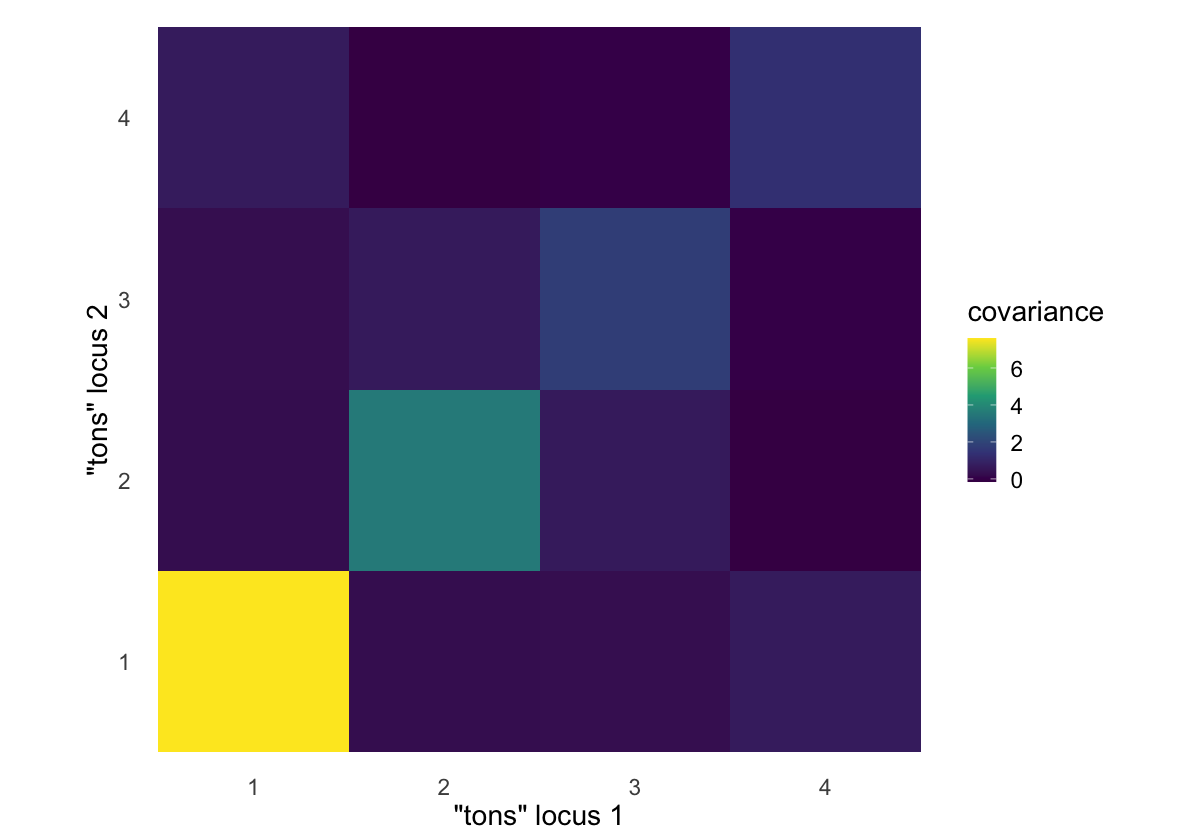

In [67]:
inv_N1 <- 1/c(1)
inv_N2 <- 1/c(1)
M1 <- c(0)
M2 <- c(10000)
R <- c(1)
epoque_params <- cbind(inv_N1, inv_N2, M1, M2, R)
times <- c(4)

s <- 5
graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 0.5, epoques=TRUE)
graph <- add_epoques_to_graph(graph, epoque_params, times)
rewards <- sapply(1:vertices_length(graph), function(index) head(vertex_at(graph, index)$state, -1))  # need the head to clip off the epoque slot...

mutation_graph <- clone_graph(graph)
print(vertices_length(mutation_graph))
rewards <- make_discrete(mutation_graph, 1)

locus1_rewards <- function(i) {
    colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
}
locus2_rewards <- function(j) {
    colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
}

fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus2_rewards(j)), a, b)
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

plot_cov_mat(cov_mat) + theme(aspect=0.95) + labs(y = '"tons" locus 2', x = '"tons" locus 1', fill='covariance')

[1] 59836


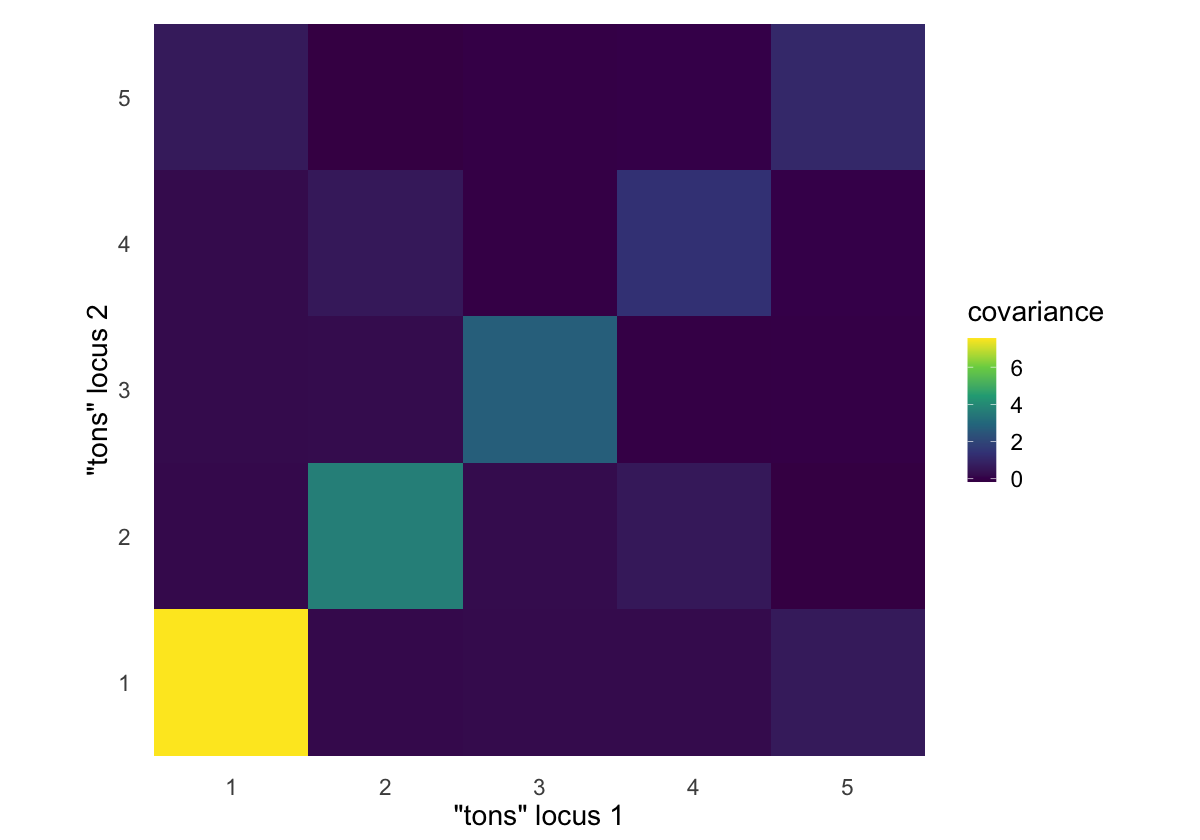

In [68]:
inv_N1 <- 1/c(1)
inv_N2 <- 1/c(1)
M1 <- c(0)
M2 <- c(10000)
R <- c(1)
epoque_params <- cbind(inv_N1, inv_N2, M1, M2, R)
times <- c(4)

s <- 6
graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 0.5, epoques=TRUE)
graph <- add_epoques_to_graph(graph, epoque_params, times)
rewards <- sapply(1:vertices_length(graph), function(index) head(vertex_at(graph, index)$state, -1))  # need the head to clip off the epoque slot...

mutation_graph <- clone_graph(graph)
print(vertices_length(mutation_graph))
rewards <- make_discrete(mutation_graph, 1)

locus1_rewards <- function(i) {
    colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
}
locus2_rewards <- function(j) {
    colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
}

fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus2_rewards(j)), a, b)
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

plot_cov_mat(cov_mat) + theme(aspect=0.95) + labs(y = '"tons" locus 2', x = '"tons" locus 1', fill='covariance')

In [ ]:
inv_N1 <- 1/c(1)
inv_N2 <- 1/c(1)
M1 <- c(0)
M2 <- c(10000)
R <- c(1)
epoque_params <- cbind(inv_N1, inv_N2, M1, M2, R)
times <- c(4)

s <- 7
graph <- construct_twolocus_island_graph(s, 1, 1, 1, 1, 0.5, epoques=TRUE)
graph <- add_epoques_to_graph(graph, epoque_params, times)
rewards <- sapply(1:vertices_length(graph), function(index) head(vertex_at(graph, index)$state, -1))  # need the head to clip off the epoque slot...

mutation_graph <- clone_graph(graph)
print(vertices_length(mutation_graph))
rewards <- make_discrete(mutation_graph, 1)

locus1_rewards <- function(i) {
    colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
}
locus2_rewards <- function(j) {
    colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
}

fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus2_rewards(j)), a, b)
cov_mat <- outer(1:(s-1), 1:(s-1), fun)

plot_cov_mat(cov_mat) + theme(aspect=0.95) + labs(y = '"tons" locus 2', x = '"tons" locus 1', fill='covariance')

In [ ]:

# self-transition rate:
mutation_rate <- 5e-10 * 20000 * 30

disc_two_locus_expectation <- function(s, N, M, R, T) 
{    
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R, epoques=TRUE)
    inv_N1 <- 1/c(N)
    inv_N2 <- 1/c(N)
    M1 <- c(0)
    M2 <- c(10000)
    R <- c(R)
    epoque_params <- cbind(inv_N1, inv_N2, M1, M2, R)
    times <- c(T)
    graph <- add_epoques_to_graph(graph, epoque_params, times)

    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, mutation_rate)
    
    exp_mat <- matrix(nrow=s-1,ncol=s-1)
    for (i in 1:(s-1)) {
      for (j in 1:(s-1)) {
        exp_mat[i,j] <- expectation(mutation_graph, rewards[props_to_index(s, i, j, 1),] + rewards[props_to_index(s, i, j, 2),])
      }
    }
    return(exp_mat)
} 

disc_ton_covariance_within_locus <- function(s, N, M, R, T) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R, epoques=TRUE)
    inv_N1 <- 1/c(N)
    inv_N2 <- 1/c(N)
    M1 <- c(0)
    M2 <- c(10000)
    R <- c(R)
    epoque_params <- cbind(inv_N1, inv_N2, M1, M2, R)
    times <- c(T)
    graph <- add_epoques_to_graph(graph, epoque_params, times)
    
    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, mutation_rate)
    
    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus1_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
}  

disc_ton_covariance_between_loci <- function(s, N, M, R, T) 
{
    graph <- construct_twolocus_island_graph(s, N, N, M, M, R, epoques=TRUE)
    inv_N1 <- 1/c(N)
    inv_N2 <- 1/c(N)
    M1 <- c(0)
    M2 <- c(10000)
    R <- c(R)
    epoque_params <- cbind(inv_N1, inv_N2, M1, M2, R)
    times <- c(T)
    graph <- add_epoques_to_graph(graph, epoque_params, times)
    
    mutation_graph <- clone_graph(graph)
    rewards <- make_discrete(mutation_graph, 1)
    
    locus1_rewards <- function(i) {
        colSums(rewards[broadcast_props_to_index(s, i, 1:s, 1),]) + colSums(rewards[broadcast_props_to_index(s, i, 1:s, 2),])
    }
    locus2_rewards <- function(j) {
        colSums(rewards[broadcast_props_to_index(s, 1:s, j, 1),]) + colSums(rewards[broadcast_props_to_index(s, 1:s, j, 2),])
    }

    fun <- function(a, b) mapply(function(i, j) covariance(mutation_graph, locus1_rewards(i), locus2_rewards(j)), a, b)
    cov_mat <- outer(1:(s-1), 1:(s-1), fun)
    return(cov_mat)
} 

In [ ]:
mat <- disc_two_locus_expectation(5, 1, 1, 0.5, 4)
plot_exp_mat(mat) +
scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
scale_fill_viridis() +
theme_minimal() +
theme(aspect=1) + labs(y = "locus 2", x = "locus 1", fill='expectation') +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

ggsave('~/Desktop/tmp.pdf', width=6, height=6)

----